In [147]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output

from tqdm import tqdm
from nba_api.stats.static import players, teams
from nba_api.stats.library.parameters import SeasonAll
from nba_api.stats.endpoints import leaguegamelog
from nba_api.stats.endpoints import playergamelogs
from nba_api.stats.endpoints import boxscoreadvancedv2
from nba_api.stats.endpoints import boxscorescoringv2


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, ElasticNet, Ridge, Lasso
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import learning_curve
from sklearn.metrics import mean_absolute_error, mean_squared_error

from time import sleep
import time

import rolling
pd.options.display.max_columns=200

In [148]:
player_gls = pd.read_csv('./data/basic_player_boxscores/player_boxscores_2010-11.csv')
player_gls_adv = pd.read_csv('./data/advanced_player_boxscores/player_advanced_boxscores_2010-11.csv')
player_gls_scoring = pd.read_csv('./data/scoring_player_boxscores/player_scoring_boxscores_2010-11.csv')

player_gls = player_gls[['SEASON_YEAR', 'PLAYER_ID', 'PLAYER_NAME', 'TEAM_ID',
       'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID', 'GAME_DATE', 'MATCHUP',
       'WL', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM',
       'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'TOV', 'STL', 'BLK',
       'BLKA', 'PF', 'PFD', 'PTS', 'PLUS_MINUS']]

player_full = pd.merge(player_gls, player_gls_adv, how='left', on=['GAME_ID', 'PLAYER_ID'], suffixes=['', '_x'])
player_full = pd.merge(player_full, player_gls_scoring, how='left', on=['GAME_ID', 'PLAYER_ID'], suffixes=['', '_x'])

player_full

,SEASON_YEAR,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,TEAM_ID_x,TEAM_ABBREVIATION_x,TEAM_CITY,PLAYER_NAME_x,START_POSITION,COMMENT,MIN_x,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,E_NET_RATING,NET_RATING,AST_PCT,AST_TOV,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,USG_PCT,E_USG_PCT,E_PACE,PACE,PACE_PER40,POSS,PIE,TEAM_ID_x,TEAM_ABBREVIATION_x,TEAM_CITY_x,PLAYER_NAME_x,START_POSITION_x,COMMENT_x,MIN_x,PCT_FGA_2PT,PCT_FGA_3PT,PCT_PTS_2PT,PCT_PTS_2PT_MR,PCT_PTS_3PT,PCT_PTS_FB,PCT_PTS_FT,PCT_PTS_OFF_TOV,PCT_PTS_PAINT,PCT_AST_2PM,PCT_UAST_2PM,PCT_AST_3PM,PCT_UAST_3PM,PCT_AST_FGM,PCT_UAST_FGM
0,2010-11,200751,Randy Foye,1610612746,LAC,Los Angeles Clippers,21001228,2011-04-13T00:00:00,LAC vs. MEM,W,19.805000,0,4,0.000,0,4,0.000,2,3,0.667,0,0,0,4,0,3,0,0,1,1,2,-2,1610612746,LAC,Los Angeles,Randy Foye,NaN,NaN,19:48,89.4,92.7,95.1,93.0,-5.7,-0.3,0.250,0.00,44.4,0.000,0.000,0.000,0.0,0.000,0.188,0.111,0.107,102.52,101.79,84.83,41,0.042,1610612746,LAC,Los Angeles,Randy Foye,NaN,NaN,19:48,0.000,1.000,0.000,0.000,0.00,0.000,1.000,0.500,0.000,0.000,0.000,0.0,0.0,0.000,0.000
1,2010-11,201196,Ramon Sessions,1610612739,CLE,Cleveland Cavaliers,21001218,2011-04-13T00:00:00,CLE vs. WAS,W,32.766667,8,13,0.615,0,1,0.000,11,12,0.917,1,3,4,3,5,0,0,1,2,7,27,-2,1610612739,CLE,Cleveland,Ramon Sessions,G,NaN,32:46,103.3,103.0,103.0,106.1,0.3,-3.0,0.188,0.60,11.5,0.036,0.077,0.060,19.2,0.615,0.739,0.307,0.316,97.97,96.68,80.57,66,0.172,1610612739,CLE,Cleveland,Ramon Sessions,G,NaN,32:46,0.923,0.077,0.593,0.222,0.00,0.222,0.407,0.148,0.370,0.500,0.500,0.0,0.0,0.500,0.500
2,2010-11,202328,Greg Monroe,1610612765,DET,Detroit Pistons,21001220,2011-04-13T00:00:00,DET @ PHI,W,31.550000,3,10,0.300,0,0,0.000,4,6,0.667,0,13,13,3,1,1,0,2,5,5,10,11,1610612765,DET,Detroit,Greg Monroe,F,NaN,31:33,106.1,109.8,88.2,88.9,18.0,20.9,0.150,3.00,17.6,0.000,0.325,0.188,5.9,0.300,0.396,0.215,0.218,96.33,94.33,78.61,61,0.116,1610612765,DET,Detroit,Greg Monroe,F,NaN,31:33,1.000,0.000,0.600,0.200,0.00,0.200,0.400,0.000,0.400,0.667,0.333,0.0,0.0,0.667,0.333
3,2010-11,201632,Hamed Haddadi,1610612763,MEM,Memphis Grizzlies,21001228,2011-04-13T00:00:00,MEM @ LAC,L,13.266667,3,5,0.600,0,0,0.000,4,5,0.800,1,2,3,0,0,1,1,0,3,3,10,11,1610612763,MEM,Memphis,Hamed Haddadi,NaN,NaN,13:16,114.6,128.6,94.7,96.2,20.0,32.4,0.000,0.00,0.0,0.091,0.154,0.125,0.0,0.600,0.694,0.226,0.216,104.56,97.69,81.41,28,0.154,1610612763,MEM,Memphis,Hamed Haddadi,NaN,NaN,13:16,1.000,0.000,0.600,0.000,0.00,0.000,0.400,0.100,0.600,1.000,0.000,0.0,0.0,1.000,0.000
4,2010-11,201611,Henry Walker,1610612752,NYK,New York Knicks,21001216,2011-04-13T00:00:00,NYK @ BOS,L,23.833333,3,6,0.500,1,3,0.333,5,6,0.833,0,3,3,2,0,0,0,0,2,3,12,2,1610612752,NYK,New York,Henry Walker,F,NaN,23:50,106.7,111.1,98.9,104.3,7.8,6.8,0.125,0.00,18.2,0.000,0.125,0.064,0.0,0.583,0.694,0.176,0.174,96.03,91.64,76.36,45,0.145,1610612752,NYK,New York,Henry Walker,F,NaN,23:50,0.500,0.500,0.333,0.000,0.25,0.167,0.417,0.250,0.333,0.500,0.500,1.0,0.0,0.667,0.333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26764,2010-11,2430,Carlos Boozer,1610612741,CHI,Chicago Bulls,41000101,2011-04-16T00:00:00,CHI vs. IND,W,26.193333,4,11,0.364,0,0,0.000,4,5,0.800,1,5,6,0,4,0,1,2,5,3,12,-5,1610612741,CHI,Chicago,Carlos Boozer,F,NaN,26:12,105.3,106.4,116.3,119.6,-11.0,-13.2,0.000,0.00,0.0,0.036,0.167,0.103,23.5,0.364,0.455,0.279,0.277,86.83,85.21,71.01,47,0.014,1610612741,CHI,Chicago,Carlos Boozer,F,NaN,26:12,1.000,0.000,0.667,0.333,0.00,0.000,0.333,0.000,0.333,0.500,0.500,0.0,0.0,0.500,0.500
26765,2010-11,101107,

In [153]:
player_gls_scoring.isnull().sum()

GAME_ID                  0
TEAM_ID                  0
TEAM_ABBREVIATION        0
TEAM_CITY                0
PLAYER_ID                0
PLAYER_NAME              0
START_POSITION       18309
COMMENT              26769
MIN                   4650
PCT_FGA_2PT           4650
PCT_FGA_3PT           4650
PCT_PTS_2PT           4650
PCT_PTS_2PT_MR        4650
PCT_PTS_3PT           4650
PCT_PTS_FB            4650
PCT_PTS_FT            4650
PCT_PTS_OFF_TOV       4650
PCT_PTS_PAINT         4650
PCT_AST_2PM           4650
PCT_UAST_2PM          4650
PCT_AST_3PM           4650
PCT_UAST_3PM          4650
PCT_AST_FGM           4650
PCT_UAST_FGM          4650
dtype: int64

In [152]:
seasons = ["200{}-0{}".format(x, x+1) if x!=9 else "200{}-{}".format(x, x+1) for x in range(0, 10)]
seasons2 = ["20{}-{}".format(x, x+1) for x in range(10, 21)]
seasons.extend(seasons2)
print(seasons)
def gather_data(seasons = seasons):
    full_player_data = []
    for season in seasons:
        player_gls = pd.read_csv('./data/basic_player_boxscores/player_boxscores_{}.csv'.format(season))
        player_gls_adv = pd.read_csv('./data/advanced_player_boxscores/player_advanced_boxscores_{}.csv'.format(season))
        player_gls_scoring = pd.read_csv('./data/scoring_player_boxscores/player_scoring_boxscores_{}.csv'.format(season))
        
        player_gls = player_gls[['SEASON_YEAR', 'PLAYER_ID', 'PLAYER_NAME', 'TEAM_ID',
       'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID', 'GAME_DATE', 'MATCHUP',
       'WL', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM',
       'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'TOV', 'STL', 'BLK',
       'BLKA', 'PF', 'PFD', 'PTS', 'PLUS_MINUS']]

        player_full = pd.merge(player_gls, player_gls_adv, how='left', on=['GAME_ID', 'PLAYER_ID'], suffixes=['', '_x'])
        player_full = pd.merge(player_full, player_gls_scoring, how='left', on=['GAME_ID', 'PLAYER_ID'], suffixes=['', '_x'])
    
        # drop unnecessary columns
        player_full = player_full.drop(columns = ['TEAM_ID', 'TEAM_NAME', 'TEAM_ID_x',
                         'TEAM_ABBREVIATION_x','TEAM_CITY','PLAYER_NAME_x','START_POSITION',
                          'COMMENT','MIN_x','TEAM_ID_x', 'TEAM_ABBREVIATION_x','TEAM_CITY_x', 
                          'PLAYER_NAME_x', 'START_POSITION_x', 'COMMENT_x', 'MIN_x', 
                         'TEAM_ID_x', 'TEAM_ABBREVIATION_x', 'TEAM_CITY_x', 'PLAYER_NAME_x', 
                          'START_POSITION_x', 'COMMENT_x', 'MIN_x', 'AST_x', 'FG_PCT_x',
                         'FG_PCT', 'FG3_PCT', 'FT_PCT', 'E_NET_RATING', 'NET_RATING', 
                         'AST_PCT', 'OREB_PCT', 'DREB_PCT', 'REB_PCT', 'EFG_PCT', 'TS_PCT', 
                         'PCT_FGA_2PT', 'PCT_FGA_3PT', 'PCT_PTS_FT', 'CFG_PCT',
                        'UFG_PCT', 'DFG_PCT'], 
                       errors= 'ignore')

        # Convert date to datetime
        player_full['GAME_DATE'] = pd.to_datetime(player_full['GAME_DATE'])
        
        # Convert W/L to a binary 1/0 for win/loss
        player_full['WL'] = (player_full['WL'].str[0] == 'W').astype(int)
        
        # Add a binary home_game feature
        player_full['HOME_GAME'] = player_full['MATCHUP'].str.contains('vs').astype(int)
        
        # convert the percentages into raw numbers (because we will be averaging them, we don't want to average percentages)
        # for example, percentage of points from midrange will be points scored from midrange
        player_full['FG2M'] = player_full['FGM'] - player_full['FG3M']
        player_full['FG2A'] = player_full['FGA'] - player_full['FG3A']
        player_full['PTS_2PT'] = (player_full['PTS'] * player_full['PCT_PTS_2PT'])
        player_full['PTS_2PT_MR'] = (player_full['PTS'] * player_full['PCT_PTS_2PT_MR'])
        player_full['PTS_3PT'] = (player_full['PTS'] * player_full['PCT_PTS_3PT'])
        player_full['PTS_FB'] = (player_full['PTS'] * player_full['PCT_PTS_FB'])
        player_full['PTS_OFF_TOV'] = (player_full['PTS'] * player_full['PCT_PTS_OFF_TOV'])
        player_full['PTS_PAINT'] = (player_full['PTS'] * player_full['PCT_PTS_PAINT'])
        player_full['AST_2PM'] = (player_full['FG2M'] * player_full['PCT_AST_2PM'])
        player_full['UAST_2PM'] = (player_full['FG2M'] * player_full['PCT_UAST_2PM'])
        player_full['AST_3PM'] = (player_full['FG3M'] * player_full['PCT_AST_3PM'])
        player_full['UAST_3PM'] = (player_full['FG3M'] * player_full['PCT_UAST_3PM'])



        player_full = player_full.drop(columns = ['PCT_PTS_2PT', 'PCT_PTS_2PT_MR', 'PCT_PTS_3PT', 
                                                  'PCT_PTS_FB', 'PCT_PTS_OFF_TOV', 'PCT_PTS_PAINT',
                                                  'PCT_AST_2PM', 'PCT_UAST_2PM', 'PCT_AST_3PM',
                                                  'PCT_UAST_3PM', 'PCT_AST_FGM', 'PCT_UAST_FGM', 
                                                  'FGM', 'FGA', 'AST_TOV', 'USG_PCT', 'PACE'], 
                                       errors='ignore')
        
        
        full_player_data.append(player_full)
        
        
    
    player_df = pd.concat(full_player_data)
    
    
    player_df['home_team_abbr'] = player_df.apply(lambda row: row['TEAM_ABBREVIATION'] if row['HOME_GAME'] == 1 else row['MATCHUP'][-3:], axis=1)
    player_df['away_team_abbr'] = player_df.apply(lambda row: row['TEAM_ABBREVIATION'] if row['HOME_GAME'] == 0 else row['MATCHUP'][-3:], axis=1)
    
    player_df[['home_team_abbr', 'away_team_abbr']] = player_df[['home_team_abbr', 'away_team_abbr']].replace({'NOH':'NOP',
                                                                                                               'NJN':'BKN'})
    
    # Fill in missing names using PLAYER_ID
    no_name_ids = player_df.loc[player_df['PLAYER_NAME'].isnull(), 'PLAYER_ID'].unique()
    no_name_ids
    for noname in no_name_ids:
        name = player_df.loc[player_df['PLAYER_ID'] == noname, 'PLAYER_NAME'].values[0]
        player_df.loc[(player_df['PLAYER_NAME'].isnull()) & (player_df['PLAYER_ID'] == noname), 'PLAYER_NAME'] = name
    
    
#     Reorder columns
    player_df = player_df[['SEASON_YEAR', 'PLAYER_ID', 'PLAYER_NAME', 
                           'TEAM_ABBREVIATION', 'home_team_abbr', 
                           'away_team_abbr', 'GAME_ID', 'GAME_DATE', 
                           'MATCHUP', 'HOME_GAME', 'WL', 'MIN', 'FG2M',
                           'FG2A','FG3M', 'FG3A', 'FTM', 'FTA',
                           'OREB', 'DREB', 'AST', 'TOV', 'STL', 
                           'BLK', 'BLKA', 'PF', 'PFD', 'PTS', 
                           'PLUS_MINUS', 'E_OFF_RATING',
                           'E_DEF_RATING', 'AST_RATIO', 
                           'TM_TOV_PCT', 'E_USG_PCT', 'PACE_PER40',
                           'POSS', 'PIE', 'PTS_2PT', 'PTS_2PT_MR', 
                           'PTS_3PT', 'PTS_FB', 'PTS_OFF_TOV', 'PTS_PAINT',
                           'AST_2PM', 'UAST_2PM', 'AST_3PM', 'UAST_3PM']]
    # Drop the 23 Null rows (one game in 2003-04 season, GAME_ID = '20300778')
    # where Advanced Stats weren't collected
    player_df = player_df.dropna()
    
    return player_df

# player_df = gather_data(seasons)

['2000-01', '2001-02', '2002-03', '2003-04', '2004-05', '2005-06', '2006-07', '2007-08', '2008-09', '2009-10', '2010-11', '2011-12', '2012-13', '2013-14', '2014-15', '2015-16', '2016-17', '2017-18', '2018-19', '2019-20', '2020-21']
ERROR! Session/line number was not unique in database. History logging moved to new session 753


In [967]:
def aggregate_player_stats(df = player_df):

    seasons = df['SEASON_YEAR'].unique()

    df = df.sort_values('GAME_DATE')
    cols = df.iloc[:, 11:].columns
    
    for season in seasons:
        season_df = df.loc[df['SEASON_YEAR'] == season]
        player_ids = season_df['PLAYER_ID'].unique()
        
        for p_id in tqdm(player_ids, desc='Progress'):
            player_log = season_df.loc[season_df['PLAYER_ID'] == p_id].sort_values('GAME_DATE')

            avg_player_data = player_log.iloc[:, 11:].shift(1).rolling(10, min_periods=5).mean()
            
            df.loc[(df['SEASON_YEAR'] == season) & (df['PLAYER_ID'] == p_id), cols] = avg_player_data

    df.to_csv('player_avg_last10.csv', index=False)
        
    return df
    
player_stats = aggregate_player_stats(df=player_df)

Progress: 100%|██████████████████████████████████████████████████████████████████████| 482/482 [01:34<00:00,  5.09it/s]


### Aggregated Data from 2000 - 2021-02-18

In [968]:
player_stats = pd.read_csv('player_avg_last10.csv')
player_stats

,SEASON_YEAR,PLAYER_ID,PLAYER_NAME,TEAM_ABBREVIATION,home_team_abbr,away_team_abbr,GAME_ID,GAME_DATE,MATCHUP,HOME_GAME,WL,MIN,FG2M,FG2A,FG3M,FG3A,FTM,FTA,OREB,DREB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,E_OFF_RATING,E_DEF_RATING,AST_RATIO,TM_TOV_PCT,E_USG_PCT,PACE_PER40,POSS,PIE,PTS_2PT,PTS_2PT_MR,PTS_3PT,PTS_FB,PTS_OFF_TOV,PTS_PAINT,AST_2PM,UAST_2PM,AST_3PM,UAST_3PM
0,2000-01,2032,Darius Miles,LAC,UTA,LAC,20000010,2000-10-31,LAC @ UTA,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000-01,1838,Tyrone Nesby,LAC,UTA,LAC,20000010,2000-10-31,LAC @ UTA,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2000-01,323,Greg Foster,LAL,POR,LAL,20000012,2000-10-31,LAL @ POR,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2000-01,243,Aaron McKie,PHI,NYK,PHI,20000001,2000-10-31,PHI @ NYK,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2000-01,1134,Ike Austin,VAN,VAN,SEA,20000013,2000-10-31,VAN vs. SEA,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
537953,2020-21,1626171,Bobby Portis,MIL,MIL,TOR,22000445,2021-02-18,MIL vs. TOR,1,0,21.591833,4.5,7.5,1.5,2.7,0.3,0.6,1.7,5.2,1.2,0.4,1.1,0.4,0.6,2.2,0.7,13.8,10.5,125.34,102.31,10.31,3.26,0.2081,86.419,46.2,0.1525,8.9991,1.7992,4.5027,0.8010,3.3002,7.1985,2.3003,2.1997,1.5,0.0
537954,2020-21,1628035,Alfonzo McKinnie,LAL,LAL,BKN,22000446,2021-02-18,LAL vs. BKN,1,0,3.186667,0.4,0.8,0.1,0.3,0.0,0.2,0.5,0.4,0.1,0.0,0.1,0.0,0.2,0.3,0.2,1.1,-1.2,87.58,104.33,5.00,0.00,0.1562,90.141,7.3,0.0581,0.8000,0.0000,0.3000,0.0000,0.4000,0.8000,0.1000,0.3000,0.1,0.0
537955,2020-21,1627761,DeAndre' Bembry,TOR,MIL,TOR,22000445,2021-02-18,TOR @ MIL,0,1,21.223000,2.1,3.1,0.7,1.3,0.6,1.1,0.5,1.7,2.4,0.5,0.9,0.3,0.1,2.0,0.7,6.9,2.7,117.26,112.15,29.93,7.08,0.1111,85.018,44.7,0.0876,4.2000,0.0000,2.1003,1.6996,2.4004,4.2000,1.6002,0.4998,0.7,0.0
537956,2020-21,202693,Markieff Morris,LAL,LAL,BKN,22000446,2021-02-18,LAL vs. BKN,1,0,15.257500,0.6,1.4,0.8,2.7,0.9,1.3,0.5,2.0,0.9,0.6,0.3,0.1,0.0,1.3,1.1,4.5,0.6,103.24,108.45,12.70,12.27,0.1571,82.704,31.7,0.0277,1.1996,0.2000,2.3997,0.2000,0.0000,0.9996,0.4000,0.2000,0.8,0.0


In [1034]:
half = int(player_stats.shape[0] / 2)
player_stats1 = player_stats.iloc[:half, :]
player_stats2 = player_stats.iloc[half:, :]

player_stats1.to_csv('player_l10_avg_part1.csv', index=False)
player_stats2.to_csv('player_l10_avg_part2.csv', index=False)

In [971]:
player_stats.isnull().sum()


SEASON_YEAR              0
PLAYER_ID                0
PLAYER_NAME              0
TEAM_ABBREVIATION        0
home_team_abbr           0
away_team_abbr           0
GAME_ID                  0
GAME_DATE                0
MATCHUP                  0
HOME_GAME                0
WL                       0
MIN                  48470
FG2M                 48470
FG2A                 48470
FG3M                 48470
FG3A                 48470
FTM                  48470
FTA                  48470
OREB                 48470
DREB                 48470
AST                  48470
TOV                  48470
STL                  48470
BLK                  48470
BLKA                 48470
PF                   48470
PFD                  48470
PTS                  48470
PLUS_MINUS           48470
E_OFF_RATING         48470
E_DEF_RATING         48470
AST_RATIO            48470
TM_TOV_PCT           48470
E_USG_PCT            48470
PACE_PER40           48470
POSS                 48470
PIE                  48470
P

In [972]:
player_stats = player_stats.dropna()

In [973]:
test2 = player_stats.loc[player_stats['GAME_ID'] == 22000445]
home = test2.loc[test2['HOME_GAME'] == 1].sort_values('MIN', ascending=False)
away = test2.loc[test2['HOME_GAME'] == 0].sort_values('MIN', ascending=False)

home_cols = home.columns[:11]
away_cols = away.columns[:11]
new_cols = ['SEASON_YEAR', 'home_team_abbr',
                'away_team_abbr', 'GAME_ID', 'GAME_DATE', 
                'MATCHUP', 'HOME_GAME', 'WL']
home_matchup_info = home[new_cols].iloc[0].values.reshape(1, -1)
home_matchup_info

home_stats = home.iloc[:10, 11:].values.reshape(1, -1)
away_stats = away.iloc[:10, 11:].values.reshape(1, -1)

print(home_stats.shape, away_stats.shape)



(1, 360) (1, 360)


In [974]:
player_stats

,SEASON_YEAR,PLAYER_ID,PLAYER_NAME,TEAM_ABBREVIATION,home_team_abbr,away_team_abbr,GAME_ID,GAME_DATE,MATCHUP,HOME_GAME,WL,MIN,FG2M,FG2A,FG3M,FG3A,FTM,FTA,OREB,DREB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,E_OFF_RATING,E_DEF_RATING,AST_RATIO,TM_TOV_PCT,E_USG_PCT,PACE_PER40,POSS,PIE,PTS_2PT,PTS_2PT_MR,PTS_3PT,PTS_FB,PTS_OFF_TOV,PTS_PAINT,AST_2PM,UAST_2PM,AST_3PM,UAST_3PM
1274,2000-01,393,Rod Strickland,WAS,WAS,BKN,20000063,2000-11-08,WAS vs. NJN,1,0,33.932000,5.2,11.2,0.0,0.2,5.0,6.8,0.4,3.4,7.2,2.0,1.8,0.4,1.0,1.4,0.0,15.4,3.2,94.30,91.38,29.20,8.78,0.2196,79.114,67.0,0.1900,10.4014,4.3968,0.0000,3.4004,1.9990,5.9968,2.4006,2.7994,0.0,0.0
1275,2000-01,1751,Jahidi White,WAS,WAS,BKN,20000063,2000-11-08,WAS vs. NJN,1,0,20.905667,2.2,4.6,0.0,0.2,3.2,6.0,3.2,4.6,0.8,2.8,0.8,1.4,0.6,3.6,0.0,7.6,1.8,94.30,92.18,6.02,29.92,0.2370,78.064,39.8,0.0842,4.4002,0.0000,0.0000,0.7992,0.6000,4.4002,0.8000,1.4000,0.0,0.0
1276,2000-01,166,Ron Harper,LAL,SAS,LAL,20000068,2000-11-08,LAL @ SAS,0,0,23.027667,1.6,3.8,0.2,0.4,0.4,0.6,1.0,2.0,2.6,1.6,1.0,1.2,0.4,1.8,0.0,4.2,0.4,94.28,92.68,29.58,15.94,0.1192,74.994,43.2,0.0842,3.1998,0.7992,0.6000,0.0000,0.3996,2.4006,0.6000,1.0000,0.2,0.0
1286,2000-01,63,Michael Smith,WAS,WAS,BKN,20000063,2000-11-08,WAS vs. NJN,1,0,19.560000,1.8,3.6,0.0,0.0,1.2,2.2,2.6,6.0,0.2,0.6,0.2,1.0,0.4,2.4,0.2,4.8,-8.4,77.14,103.42,4.00,9.00,0.1240,81.994,39.0,0.2070,3.6008,0.3996,0.0000,0.3996,0.7996,3.2012,1.2002,0.5998,0.0,0.0
1299,2000-01,2034,Mike Miller,ORL,ORL,CHH,20000064,2000-11-08,ORL vs. CHH,1,0,27.749333,1.8,3.8,0.8,3.2,2.2,3.0,1.6,3.2,0.8,2.0,1.0,0.2,0.0,3.2,0.0,8.2,2.6,95.94,91.40,5.26,20.68,0.1380,85.052,59.2,0.0448,3.5988,0.7990,2.4004,3.3984,2.7994,2.7998,0.6000,1.2000,0.6,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
537953,2020-21,1626171,Bobby Portis,MIL,MIL,TOR,22000445,2021-02-18,MIL vs. TOR,1,0,21.591833,4.5,7.5,1.5,2.7,0.3,0.6,1.7,5.2,1.2,0.4,1.1,0.4,0.6,2.2,0.7,13.8,10.5,125.34,102.31,10.31,3.26,0.2081,86.419,46.2,0.1525,8.9991,1.7992,4.5027,0.8010,3.3002,7.1985,2.3003,2.1997,1.5,0.0
537954,2020-21,1628035,Alfonzo McKinnie,LAL,LAL,BKN,22000446,2021-02-18,LAL vs. BKN,1,0,3.186667,0.4,0.8,0.1,0.3,0.0,0.2,0.5,0.4,0.1,0.0,0.1,0.0,0.2,0.3,0.2,1.1,-1.2,87.58,104.33,5.00,0.00,0.1562,90.141,7.3,0.0581,0.8000,0.0000,0.3000,0.0000,0.4000,0.8000,0.1000,0.3000,0.1,0.0
537955,2020-21,1627761,DeAndre' Bembry,TOR,MIL,TOR,22000445,2021-02-18,TOR @ MIL,0,1,21.223000,2.1,3.1,0.7,1.3,0.6,1.1,0.5,1.7,2.4,0.5,0.9,0.3,0.1,2.0,0.7,6.9,2.7,117.26,112.15,29.93,7.08,0.1111,85.018,44.7,0.0876,4.2000,0.0000,2.1003,1.6996,2.4004,4.2000,1.6002,0.4998,0.7,0.0
537956,2020-21,202693,Markieff Morris,LAL,LAL,BKN,22000446,2021-02-18,LAL vs. BKN,1,0,15.257500,0.6,1.4,0.8,2.7,0.9,1.3,0.5,2.0,0.9,0.6,0.3,0.1,0.0,1.3,1.1,4.5,0.6,103.24,108.45,12.70,12.27,0.1571,82.704,31.7,0.0277,1.1996,0.2000,2.3997,0.2000,0.0000,0.9996,0.4000,0.2000,0.8,0.0


In [1018]:
player_stats

,SEASON_YEAR,PLAYER_ID,PLAYER_NAME,TEAM_ABBREVIATION,home_team_abbr,away_team_abbr,GAME_ID,GAME_DATE,MATCHUP,HOME_GAME,WL,MIN,FG2M,FG2A,FG3M,FG3A,FTM,FTA,OREB,DREB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,E_OFF_RATING,E_DEF_RATING,AST_RATIO,TM_TOV_PCT,E_USG_PCT,PACE_PER40,POSS,PIE,PTS_2PT,PTS_2PT_MR,PTS_3PT,PTS_FB,PTS_OFF_TOV,PTS_PAINT,AST_2PM,UAST_2PM,AST_3PM,UAST_3PM
1274,2000-01,393,Rod Strickland,WAS,WAS,BKN,20000063,2000-11-08,WAS vs. NJN,1,0,33.932000,5.2,11.2,0.0,0.2,5.0,6.8,0.4,3.4,7.2,2.0,1.8,0.4,1.0,1.4,0.0,15.4,3.2,94.30,91.38,29.20,8.78,0.2196,79.114,67.0,0.1900,10.4014,4.3968,0.0000,3.4004,1.9990,5.9968,2.4006,2.7994,0.0,0.0
1275,2000-01,1751,Jahidi White,WAS,WAS,BKN,20000063,2000-11-08,WAS vs. NJN,1,0,20.905667,2.2,4.6,0.0,0.2,3.2,6.0,3.2,4.6,0.8,2.8,0.8,1.4,0.6,3.6,0.0,7.6,1.8,94.30,92.18,6.02,29.92,0.2370,78.064,39.8,0.0842,4.4002,0.0000,0.0000,0.7992,0.6000,4.4002,0.8000,1.4000,0.0,0.0
1276,2000-01,166,Ron Harper,LAL,SAS,LAL,20000068,2000-11-08,LAL @ SAS,0,0,23.027667,1.6,3.8,0.2,0.4,0.4,0.6,1.0,2.0,2.6,1.6,1.0,1.2,0.4,1.8,0.0,4.2,0.4,94.28,92.68,29.58,15.94,0.1192,74.994,43.2,0.0842,3.1998,0.7992,0.6000,0.0000,0.3996,2.4006,0.6000,1.0000,0.2,0.0
1286,2000-01,63,Michael Smith,WAS,WAS,BKN,20000063,2000-11-08,WAS vs. NJN,1,0,19.560000,1.8,3.6,0.0,0.0,1.2,2.2,2.6,6.0,0.2,0.6,0.2,1.0,0.4,2.4,0.2,4.8,-8.4,77.14,103.42,4.00,9.00,0.1240,81.994,39.0,0.2070,3.6008,0.3996,0.0000,0.3996,0.7996,3.2012,1.2002,0.5998,0.0,0.0
1299,2000-01,2034,Mike Miller,ORL,ORL,CHH,20000064,2000-11-08,ORL vs. CHH,1,0,27.749333,1.8,3.8,0.8,3.2,2.2,3.0,1.6,3.2,0.8,2.0,1.0,0.2,0.0,3.2,0.0,8.2,2.6,95.94,91.40,5.26,20.68,0.1380,85.052,59.2,0.0448,3.5988,0.7990,2.4004,3.3984,2.7994,2.7998,0.6000,1.2000,0.6,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
537953,2020-21,1626171,Bobby Portis,MIL,MIL,TOR,22000445,2021-02-18,MIL vs. TOR,1,0,21.591833,4.5,7.5,1.5,2.7,0.3,0.6,1.7,5.2,1.2,0.4,1.1,0.4,0.6,2.2,0.7,13.8,10.5,125.34,102.31,10.31,3.26,0.2081,86.419,46.2,0.1525,8.9991,1.7992,4.5027,0.8010,3.3002,7.1985,2.3003,2.1997,1.5,0.0
537954,2020-21,1628035,Alfonzo McKinnie,LAL,LAL,BKN,22000446,2021-02-18,LAL vs. BKN,1,0,3.186667,0.4,0.8,0.1,0.3,0.0,0.2,0.5,0.4,0.1,0.0,0.1,0.0,0.2,0.3,0.2,1.1,-1.2,87.58,104.33,5.00,0.00,0.1562,90.141,7.3,0.0581,0.8000,0.0000,0.3000,0.0000,0.4000,0.8000,0.1000,0.3000,0.1,0.0
537955,2020-21,1627761,DeAndre' Bembry,TOR,MIL,TOR,22000445,2021-02-18,TOR @ MIL,0,1,21.223000,2.1,3.1,0.7,1.3,0.6,1.1,0.5,1.7,2.4,0.5,0.9,0.3,0.1,2.0,0.7,6.9,2.7,117.26,112.15,29.93,7.08,0.1111,85.018,44.7,0.0876,4.2000,0.0000,2.1003,1.6996,2.4004,4.2000,1.6002,0.4998,0.7,0.0
537956,2020-21,202693,Markieff Morris,LAL,LAL,BKN,22000446,2021-02-18,LAL vs. BKN,1,0,15.257500,0.6,1.4,0.8,2.7,0.9,1.3,0.5,2.0,0.9,0.6,0.3,0.1,0.0,1.3,1.1,4.5,0.6,103.24,108.45,12.70,12.27,0.1571,82.704,31.7,0.0277,1.1996,0.2000,2.3997,0.2000,0.0000,0.9996,0.4000,0.2000,0.8,0.0


In [1010]:
test = player_stats.loc[player_stats['SEASON_YEAR'] == '2000-01']
test = test.loc[test['GAME_ID'] == 20000068]
test.iloc[:10, 11:]

,MIN,FG2M,FG2A,FG3M,FG3A,FTM,FTA,OREB,DREB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,E_OFF_RATING,E_DEF_RATING,AST_RATIO,TM_TOV_PCT,E_USG_PCT,PACE_PER40,POSS,PIE,PTS_2PT,PTS_2PT_MR,PTS_3PT,PTS_FB,PTS_OFF_TOV,PTS_PAINT,AST_2PM,UAST_2PM,AST_3PM,UAST_3PM
1276,23.027667,1.6,3.8,0.2,0.4,0.4,0.6,1.0,2.0,2.6,1.6,1.0,1.2,0.4,1.8,0.0,4.2,0.4,94.28,92.68,29.58,15.94,0.1192,74.994,43.2,0.0842,3.1998,0.7992,0.6000,0.0000,0.3996,2.4006,0.6000,1.0000,0.2,0.0
1334,22.609667,1.2,3.2,0.8,2.4,0.6,0.8,0.4,3.6,3.0,2.0,0.2,0.6,0.6,2.6,0.0,5.4,2.2,96.70,90.96,24.12,18.76,0.1716,74.688,41.8,0.0640,2.4000,0.7996,2.4006,1.5994,1.7994,1.6004,1.2000,0.0000,0.6,0.2
1349,4.385000,0.6,1.2,0.0,0.0,0.0,0.0,0.2,1.0,0.4,0.4,0.2,0.0,0.0,1.2,0.0,1.2,-4.2,65.04,101.84,20.00,8.00,0.1532,79.478,8.8,0.1238,1.2000,1.2000,0.0000,0.0000,0.0000,0.0000,0.4000,0.2000,0.0,0.0
1374,14.409667,1.4,2.4,0.4,1.6,0.8,0.8,0.2,1.2,2.2,1.4,0.4,0.0,0.2,1.8,0.0,4.8,-1.4,97.98,107.72,27.46,19.08,0.1816,79.900,29.2,0.0778,2.8008,1.2004,1.2006,0.0000,1.8000,1.6004,0.6000,0.8000,0.4,0.0
1405,24.400667,3.4,5.6,0.8,2.8,2.0,2.2,0.4,2.0,2.6,2.2,0.6,0.2,0.4,1.8,0.0,11.2,-0.6,100.08,105.52,15.46,18.16,0.2120,79.526,48.4,0.0346,6.8012,3.9994,2.4018,2.8012,3.0018,2.8018,1.3998,2.0002,0.6,0.2
1425,36.589333,2.8,6.4,0.0,0.2,1.4,2.0,3.6,4.8,0.8,0.6,0.2,0.4,0.2,3.4,0.0,7.0,5.2,100.00,94.52,6.82,4.60,0.1020,75.982,69.4,0.0592,5.6006,1.6018,0.0000,0.4000,0.4000,3.9988,2.3998,0.4002,0.0,0.0
1450,40.120000,6.0,14.2,1.0,2.2,5.6,6.2,0.8,3.0,3.6,3.6,1.6,1.0,0.6,3.0,0.0,20.6,5.2,105.38,98.52,14.10,14.20,0.2558,76.576,77.0,0.1108,11.9970,4.0044,3.0010,3.7968,2.3966,8.0060,2.5996,3.4004,0.8,0.2
1468,43.030667,12.6,21.8,0.0,0.2,6.8,16.0,3.2,9.2,4.0,2.0,0.8,3.0,0.8,3.2,0.0,32.0,7.2,103.12,95.70,11.44,5.90,0.3278,76.106,81.6,0.2054,25.2052,4.0032,0.0000,2.0014,5.8034,21.1952,9.0022,3.5978,0.0,0.0


In [1017]:
test = player_stats.loc[player_stats['SEASON_YEAR'] == '2000-01']
test = test.loc[test['GAME_ID'] == 20000068]
test

# home = test.loc[test['HOME_GAME'] == 1]
# away = test.loc[test['HOME_GAME'] == 0]
# new_cols = ['SEASON_YEAR', 'home_team_abbr',
#                 'away_team_abbr', 'GAME_ID', 'GAME_DATE', 
#                 'MATCHUP', 'HOME_GAME', 'WL']

# # home[new_cols]
# home
# # matchup_info = home[new_cols].values[0].reshape(1, -1)
# matchup_info

# home_stats = home.iloc[:10, 11:].values

# if home_stats.shape[0] < 10:
#     rows_to_add = 10 - home_stats.shape[0]
#     padding = np.zeros((rows_to_add, home_stats.shape[1]))
#     home_stats = np.concatenate((home_stats, padding), axis=0)



# home_stats_row = home_stats.reshape(1, -1)
# print(home_matchup_info.shape, home_stats_row.shape)
# home_stats_row = np.concatenate((home_matchup_info, home_stats_row), axis=1)
# home_stats_row

,SEASON_YEAR,PLAYER_ID,PLAYER_NAME,TEAM_ABBREVIATION,home_team_abbr,away_team_abbr,GAME_ID,GAME_DATE,MATCHUP,HOME_GAME,WL,MIN,FG2M,FG2A,FG3M,FG3A,FTM,FTA,OREB,DREB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,E_OFF_RATING,E_DEF_RATING,AST_RATIO,TM_TOV_PCT,E_USG_PCT,PACE_PER40,POSS,PIE,PTS_2PT,PTS_2PT_MR,PTS_3PT,PTS_FB,PTS_OFF_TOV,PTS_PAINT,AST_2PM,UAST_2PM,AST_3PM,UAST_3PM
1276,2000-01,166,Ron Harper,LAL,SAS,LAL,20000068,2000-11-08,LAL @ SAS,0,0,23.027667,1.6,3.8,0.2,0.4,0.4,0.6,1.0,2.0,2.6,1.6,1.0,1.2,0.4,1.8,0.0,4.2,0.4,94.28,92.68,29.58,15.94,0.1192,74.994,43.2,0.0842,3.1998,0.7992,0.6000,0.0000,0.3996,2.4006,0.6000,1.0000,0.2,0.0
1334,2000-01,296,Rick Fox,LAL,SAS,LAL,20000068,2000-11-08,LAL @ SAS,0,0,22.609667,1.2,3.2,0.8,2.4,0.6,0.8,0.4,3.6,3.0,2.0,0.2,0.6,0.6,2.6,0.0,5.4,2.2,96.70,90.96,24.12,18.76,0.1716,74.688,41.8,0.0640,2.4000,0.7996,2.4006,1.5994,1.7994,1.6004,1.2000,0.0000,0.6,0.2
1349,2000-01,323,Greg Foster,LAL,SAS,LAL,20000068,2000-11-08,LAL @ SAS,0,0,4.385000,0.6,1.2,0.0,0.0,0.0,0.0,0.2,1.0,0.4,0.4,0.2,0.0,0.0,1.2,0.0,1.2,-4.2,65.04,101.84,20.00,8.00,0.1532,79.478,8.8,0.1238,1.2000,1.2000,0.0000,0.0000,0.0000,0.0000,0.4000,0.2000,0.0,0.0
1374,2000-01,216,Brian Shaw,LAL,SAS,LAL,20000068,2000-11-08,LAL @ SAS,0,0,14.409667,1.4,2.4,0.4,1.6,0.8,0.8,0.2,1.2,2.2,1.4,0.4,0.0,0.2,1.8,0.0,4.8,-1.4,97.98,107.72,27.46,19.08,0.1816,79.900,29.2,0.0778,2.8008,1.2004,1.2006,0.0000,1.8000,1.6004,0.6000,0.8000,0.4,0.0
1405,2000-01,375,Isaiah Rider,LAL,SAS,LAL,20000068,2000-11-08,LAL @ SAS,0,0,24.400667,3.4,5.6,0.8,2.8,2.0,2.2,0.4,2.0,2.6,2.2,0.6,0.2,0.4,1.8,0.0,11.2,-0.6,100.08,105.52,15.46,18.16,0.2120,79.526,48.4,0.0346,6.8012,3.9994,2.4018,2.8012,3.0018,2.8018,1.3998,2.0002,0.6,0.2
1425,2000-01,270,Horace Grant,LAL,SAS,LAL,20000068,2000-11-08,LAL @ SAS,0,0,36.589333,2.8,6.4,0.0,0.2,1.4,2.0,3.6,4.8,0.8,0.6,0.2,0.4,0.2,3.4,0.0,7.0,5.2,100.00,94.52,6.82,4.60,0.1020,75.982,69.4,0.0592,5.6006,1.6018,0.0000,0.4000,0.4000,3.9988,2.3998,0.4002,0.0,0.0
1450,2000-01,977,Kobe Bryant,LAL,SAS,LAL,20000068,2000-11-08,LAL @ SAS,0,0,40.120000,6.0,14.2,1.0,2.2,5.6,6.2,0.8,3.0,3.6,3.6,1.6,1.0,0.6,3.0,0.0,20.6,5.2,105.38,98.52,14.10,14.20,0.2558,76.576,77.0,0.1108,11.9970,4.0044,3.0010,3.7968,2.3966,8.0060,2.5996,3.4004,0.8,0.2
1468,2000-01,406,Shaquille O'Neal,LAL,SAS,LAL,20000068,2000-11-08,LAL @ SAS,0,0,43.030667,12.6,21.8,0.0,0.2,6.8,16.0,3.2,9.2,4.0,2.0,0.8,3.0,0.8,3.2,0.0,32.0,7.2,103.12,95.70,11.44,5.90,0.3278,76.106,81.6,0.2054,25.2052,4.0032,0.0000,2.0014,5.8034,21.1952,9.0022,3.5978,0.0,0.0


In [1021]:
def long_to_wide(df = player_stats):
    
    
    new_cols = ['SEASON_YEAR', 'home_team_abbr',
                'away_team_abbr', 'GAME_ID', 'GAME_DATE', 
                'MATCHUP', 'HOME_GAME', 'WL']
    

    # Number of columns in player_stats minus the 11 matchup info columns
    num_stat_cols = df.shape[1] - 11
    
    matchup_data = []
       
    
    # All game_ids
    game_ids = df['GAME_ID'].unique()
     
    for game_id in tqdm(game_ids, desc="Progress"):
        
        # Select all the players boxscores from one game
        game_df = df.loc[df['GAME_ID'] == game_id]
               
        # Select the home team players, sort by minutes
        home_team = game_df.loc[game_df['HOME_GAME'] == 1].sort_values('MIN', ascending=False)        
        away_team = game_df.loc[game_df['HOME_GAME'] == 0].sort_values('MIN', ascending=False)
        
        # one of the teams games were removed (because they were in the first 5 games of season)
        if (home_team.shape[0] == 0) or (away_team.shape[0] == 0):
            continue
        
        # Select matchup info
        home_matchup_info = home_team[new_cols].values[0].reshape(1, -1)

        # unroll the players' stats up to player 10 into one long row
        home_stats = home_team.iloc[:10, 11:].values
        away_stats = away_team.iloc[:10, 11:].values        

        if home_stats.shape[0] < 10:
            rows_to_add = 10 - home_stats.shape[0]
            padding = np.zeros((rows_to_add, home_stats.shape[1]))
            home_stats = np.concatenate((home_stats, padding), axis=0) 

        home_stats_row = home_stats.reshape(1, -1)
        home_stats_row = np.concatenate([home_matchup_info, home_stats_row], axis=1)
        
        if away_stats.shape[0] < 10:
            rows_to_add = 10 - away_stats.shape[0]
            padding = np.zeros((rows_to_add, away_stats.shape[1]))
            away_stats = np.concatenate((away_stats, padding), axis=0)
        
        away_stats_row = away_stats.reshape(1, -1)    
    
        matchup_row = np.concatenate([home_stats_row, away_stats_row], axis=1)    
#         print(matchup_row)

        matchup_data.append(matchup_row.flatten())
#     print(len(matchup_data))
    matchup_data = np.array(matchup_data)
#     print(matchup_data.shape)
#     print(matchup_data)
    for i in range(1, 11):
        home_player_cols = ['home_P{}_'.format(i) + x for x in df.columns[11:]]
        new_cols.extend(home_player_cols)
    
    for i in range(1, 11):
        away_player_cols = ['away_P{}_'.format(i) + x for x in df.columns[11:]]
        new_cols.extend(away_player_cols)
        
    matchup_df = pd.DataFrame((matchup_data), columns = new_cols)
    
    return matchup_df


matchup_df = long_to_wide(df=player_stats)
matchup_df.to_csv("matchup_boxscores_wide.csv", index=False)
matchup_df
    

Progress: 100%|█████████████████████████████████████████████████████████████████| 24630/24630 [01:43<00:00, 237.41it/s]


,SEASON_YEAR,home_team_abbr,away_team_abbr,GAME_ID,GAME_DATE,MATCHUP,HOME_GAME,WL,home_P1_MIN,home_P1_FG2M,home_P1_FG2A,home_P1_FG3M,home_P1_FG3A,home_P1_FTM,home_P1_FTA,home_P1_OREB,home_P1_DREB,home_P1_AST,home_P1_TOV,home_P1_STL,home_P1_BLK,home_P1_BLKA,home_P1_PF,home_P1_PFD,home_P1_PTS,home_P1_PLUS_MINUS,home_P1_E_OFF_RATING,home_P1_E_DEF_RATING,home_P1_AST_RATIO,home_P1_TM_TOV_PCT,home_P1_E_USG_PCT,home_P1_PACE_PER40,home_P1_POSS,home_P1_PIE,home_P1_PTS_2PT,home_P1_PTS_2PT_MR,home_P1_PTS_3PT,home_P1_PTS_FB,home_P1_PTS_OFF_TOV,home_P1_PTS_PAINT,home_P1_AST_2PM,home_P1_UAST_2PM,home_P1_AST_3PM,home_P1_UAST_3PM,home_P2_MIN,home_P2_FG2M,home_P2_FG2A,home_P2_FG3M,home_P2_FG3A,home_P2_FTM,home_P2_FTA,home_P2_OREB,home_P2_DREB,home_P2_AST,home_P2_TOV,home_P2_STL,home_P2_BLK,home_P2_BLKA,home_P2_PF,home_P2_PFD,home_P2_PTS,home_P2_PLUS_MINUS,home_P2_E_OFF_RATING,home_P2_E_DEF_RATING,home_P2_AST_RATIO,home_P2_TM_TOV_PCT,home_P2_E_USG_PCT,home_P2_PACE_PER40,home_P2_POSS,home_P2_PIE,home_P2_PTS_2PT,home_P2_PTS_2PT_MR,home_P2_PTS_3PT,home_P2_PTS_FB,home_P2_PTS_OFF_TOV,home_P2_PTS_PAINT,home_P2_AST_2PM,home_P2_UAST_2PM,home_P2_AST_3PM,home_P2_UAST_3PM,home_P3_MIN,home_P3_FG2M,home_P3_FG2A,home_P3_FG3M,home_P3_FG3A,home_P3_FTM,home_P3_FTA,home_P3_OREB,home_P3_DREB,home_P3_AST,home_P3_TOV,home_P3_STL,home_P3_BLK,home_P3_BLKA,home_P3_PF,home_P3_PFD,home_P3_PTS,home_P3_PLUS_MINUS,home_P3_E_OFF_RATING,home_P3_E_DEF_RATING,...,away_P8_DREB,away_P8_AST,away_P8_TOV,away_P8_STL,away_P8_BLK,away_P8_BLKA,away_P8_PF,away_P8_PFD,away_P8_PTS,away_P8_PLUS_MINUS,away_P8_E_OFF_RATING,away_P8_E_DEF_RATING,away_P8_AST_RATIO,away_P8_TM_TOV_PCT,away_P8_E_USG_PCT,away_P8_PACE_PER40,away_P8_POSS,away_P8_PIE,away_P8_PTS_2PT,away_P8_PTS_2PT_MR,away_P8_PTS_3PT,away_P8_PTS_FB,away_P8_PTS_OFF_TOV,away_P8_PTS_PAINT,away_P8_AST_2PM,away_P8_UAST_2PM,away_P8_AST_3PM,away_P8_UAST_3PM,away_P9_MIN,away_P9_FG2M,away_P9_FG2A,away_P9_FG3M,away_P9_FG3A,away_P9_FTM,away_P9_FTA,away_P9_OREB,away_P9_DREB,away_P9_AST,away_P9_TOV,away_P9_STL,away_P9_BLK,away_P9_BLKA,away_P9_PF,away_P9_PFD,away_P9_PTS,away_P9_PLUS_MINUS,away_P9_E_OFF_RATING,away_P9_E_DEF_RATING,away_P9_AST_RATIO,away_P9_TM_TOV_PCT,away_P9_E_USG_PCT,away_P9_PACE_PER40,away_P9_POSS,away_P9_PIE,away_P9_PTS_2PT,away_P9_PTS_2PT_MR,away_P9_PTS_3PT,away_P9_PTS_FB,away_P9_PTS_OFF_TOV,away_P9_PTS_PAINT,away_P9_AST_2PM,away_P9_UAST_2PM,away_P9_AST_3PM,away_P9_UAST_3PM,away_P10_MIN,away_P10_FG2M,away_P10_FG2A,away_P10_FG3M,away_P10_FG3A,away_P10_FTM,away_P10_FTA,away_P10_OREB,away_P10_DREB,away_P10_AST,away_P10_TOV,away_P10_STL,away_P10_BLK,away_P10_BLKA,away_P10_PF,away_P10_PFD,away_P10_PTS,away_P10_PLUS_MINUS,away_P10_E_OFF_RATING,away_P10_E_DEF_RATING,away_P10_AST_RATIO,away_P10_TM_TOV_PCT,away_P10_E_USG_PCT,away_P10_PACE_PER40,away_P10_POSS,away_P10_PIE,away_P10_PTS_2PT,away_P10_PTS_2PT_MR,away_P10_PTS_3PT,away_P10_PTS_FB,away_P10_PTS_OFF_TOV,away_P10_PTS_PAINT,away_P10_AST_2PM,away_P10_UAST_2PM,away_P10_AST_3PM,away_P10_UAST_3PM
0,2000-01,PHX,ATL,20000077,2000-11-09,PHX vs. ATL,1,1,41.8293,4,9.4,1.6,3.4,5.2,6.2,0.8,6.6,10.6,4.8,3.2,0.2,0.8,3.2,0,18,9.2,102.96,93.06,35.58,15.52,0.2046,81.06,84.8,0.1794,7.9996,1.6004,4.8012,3.6004,4.2008,6.3992,1.2006,2.7994,1.4,0.2,38.26,6.6,14.4,0.6,4.2,4,5.2,2,2,3.8,1.6,1.8,1.6,1.4,2,0,19,1.6,98.52,98.16,14.9,6.42,0.2732,78.264,75,0.0996,13.1982,3.2046,1.8012,2.0008,4.0036,9.996,5.2008,1.3992,0.6,0,36.473,6.6,11,0.8,2.8,2.6,3,2,6,1.6,1.8,1.6,1.6,0.4,2.6,0,18.2,4.2,97.56,94.4,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2000-01,HOU,VAN,20000076,2000-11-09,HOU vs. VAN,1,1,39.04,4.6,11.8,1.4,2.8,5.6,6.2,2.8,2.8,6.6,4,1.6,0.4,0.8,3.4,0,19,2,103.3,101.32,25.04,12.78,0.2424,77.266,75,0.1356,9.198,2.796,4.2018,1.8,3.5988,6.402,1.8,2.8,0.8,0.6,35.0753,2.8,5.4,1,3,4.2,5.6,1.4,3.4,1.8,1.6,1,0.4,0.6,2.2,0,12.8,1.8,101.02,101.42,14.16,9.

Split up DataFrame to save into smaller files:

In [1030]:
half = int(matchup_df.shape[0]/2)

matchup_df1 = matchup_df.iloc[:half, :]
matchup_df2 = matchup_df.iloc[half:, :]

matchup_df1.to_csv("matchup_boxscores_wide_part1.csv", index=False)
matchup_df2.to_csv("matchup_boxscores_wide_part2.csv", index=False)

## Matchup Data - Run from here to avoid having to run prior functions

In [4]:
matchup_df1 = pd.read_csv('matchup_boxscores_wide_part1.csv', parse_dates=['GAME_DATE'])
matchup_df2 = pd.read_csv('matchup_boxscores_wide_part2.csv', parse_dates=['GAME_DATE'])

matchup_df = pd.concat([matchup_df1, matchup_df2])

In [5]:
matchup_df

,SEASON_YEAR,home_team_abbr,away_team_abbr,GAME_ID,GAME_DATE,MATCHUP,HOME_GAME,WL,home_P1_MIN,home_P1_FG2M,home_P1_FG2A,home_P1_FG3M,home_P1_FG3A,home_P1_FTM,home_P1_FTA,home_P1_OREB,home_P1_DREB,home_P1_AST,home_P1_TOV,home_P1_STL,home_P1_BLK,home_P1_BLKA,home_P1_PF,home_P1_PFD,home_P1_PTS,home_P1_PLUS_MINUS,home_P1_E_OFF_RATING,home_P1_E_DEF_RATING,home_P1_AST_RATIO,home_P1_TM_TOV_PCT,home_P1_E_USG_PCT,home_P1_PACE_PER40,home_P1_POSS,home_P1_PIE,home_P1_PTS_2PT,home_P1_PTS_2PT_MR,home_P1_PTS_3PT,home_P1_PTS_FB,home_P1_PTS_OFF_TOV,home_P1_PTS_PAINT,home_P1_AST_2PM,home_P1_UAST_2PM,home_P1_AST_3PM,home_P1_UAST_3PM,home_P2_MIN,home_P2_FG2M,home_P2_FG2A,home_P2_FG3M,home_P2_FG3A,home_P2_FTM,home_P2_FTA,home_P2_OREB,home_P2_DREB,home_P2_AST,home_P2_TOV,home_P2_STL,home_P2_BLK,home_P2_BLKA,home_P2_PF,home_P2_PFD,home_P2_PTS,home_P2_PLUS_MINUS,home_P2_E_OFF_RATING,home_P2_E_DEF_RATING,home_P2_AST_RATIO,home_P2_TM_TOV_PCT,home_P2_E_USG_PCT,home_P2_PACE_PER40,home_P2_POSS,home_P2_PIE,home_P2_PTS_2PT,home_P2_PTS_2PT_MR,home_P2_PTS_3PT,home_P2_PTS_FB,home_P2_PTS_OFF_TOV,home_P2_PTS_PAINT,home_P2_AST_2PM,home_P2_UAST_2PM,home_P2_AST_3PM,home_P2_UAST_3PM,home_P3_MIN,home_P3_FG2M,home_P3_FG2A,home_P3_FG3M,home_P3_FG3A,home_P3_FTM,home_P3_FTA,home_P3_OREB,home_P3_DREB,home_P3_AST,home_P3_TOV,home_P3_STL,home_P3_BLK,home_P3_BLKA,home_P3_PF,home_P3_PFD,home_P3_PTS,home_P3_PLUS_MINUS,home_P3_E_OFF_RATING,home_P3_E_DEF_RATING,...,away_P8_DREB,away_P8_AST,away_P8_TOV,away_P8_STL,away_P8_BLK,away_P8_BLKA,away_P8_PF,away_P8_PFD,away_P8_PTS,away_P8_PLUS_MINUS,away_P8_E_OFF_RATING,away_P8_E_DEF_RATING,away_P8_AST_RATIO,away_P8_TM_TOV_PCT,away_P8_E_USG_PCT,away_P8_PACE_PER40,away_P8_POSS,away_P8_PIE,away_P8_PTS_2PT,away_P8_PTS_2PT_MR,away_P8_PTS_3PT,away_P8_PTS_FB,away_P8_PTS_OFF_TOV,away_P8_PTS_PAINT,away_P8_AST_2PM,away_P8_UAST_2PM,away_P8_AST_3PM,away_P8_UAST_3PM,away_P9_MIN,away_P9_FG2M,away_P9_FG2A,away_P9_FG3M,away_P9_FG3A,away_P9_FTM,away_P9_FTA,away_P9_OREB,away_P9_DREB,away_P9_AST,away_P9_TOV,away_P9_STL,away_P9_BLK,away_P9_BLKA,away_P9_PF,away_P9_PFD,away_P9_PTS,away_P9_PLUS_MINUS,away_P9_E_OFF_RATING,away_P9_E_DEF_RATING,away_P9_AST_RATIO,away_P9_TM_TOV_PCT,away_P9_E_USG_PCT,away_P9_PACE_PER40,away_P9_POSS,away_P9_PIE,away_P9_PTS_2PT,away_P9_PTS_2PT_MR,away_P9_PTS_3PT,away_P9_PTS_FB,away_P9_PTS_OFF_TOV,away_P9_PTS_PAINT,away_P9_AST_2PM,away_P9_UAST_2PM,away_P9_AST_3PM,away_P9_UAST_3PM,away_P10_MIN,away_P10_FG2M,away_P10_FG2A,away_P10_FG3M,away_P10_FG3A,away_P10_FTM,away_P10_FTA,away_P10_OREB,away_P10_DREB,away_P10_AST,away_P10_TOV,away_P10_STL,away_P10_BLK,away_P10_BLKA,away_P10_PF,away_P10_PFD,away_P10_PTS,away_P10_PLUS_MINUS,away_P10_E_OFF_RATING,away_P10_E_DEF_RATING,away_P10_AST_RATIO,away_P10_TM_TOV_PCT,away_P10_E_USG_PCT,away_P10_PACE_PER40,away_P10_POSS,away_P10_PIE,away_P10_PTS_2PT,away_P10_PTS_2PT_MR,away_P10_PTS_3PT,away_P10_PTS_FB,away_P10_PTS_OFF_TOV,away_P10_PTS_PAINT,away_P10_AST_2PM,away_P10_UAST_2PM,away_P10_AST_3PM,away_P10_UAST_3PM
0,2000-01,PHX,ATL,20000077,2000-11-09,PHX vs. ATL,1,1,41.829333,4.0,9.4,1.6,3.4,5.2,6.2,0.8,6.6,10.6,4.8,3.2,0.2,0.8,3.2,0.0,18.0,9.2,102.96,93.06,35.58,15.52,0.2046,81.060,84.8,0.1794,7.9996,1.6004,4.8012,3.6004,4.2008,6.3992,1.2006,2.7994,1.4000,0.2000,38.260000,6.6,14.4,0.6,4.2,4.0,5.2,2.0,2.0,3.8,1.6,1.8,1.6,1.4,2.0,0.0,19.0,1.6,98.52,98.16,14.90,6.42,0.2732,78.264,75.0,0.0996,13.1982,3.2046,1.8012,2.0008,4.0036,9.9960,5.2008,1.3992,0.6000,0.0000,36.473000,6.6,11.0,0.8,2.8,2.6,3.0,2.0,6.0,1.6,1.8,1.6,1.6,0.4,2.6,0.0,18.2,4.2,97.56,94.40,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0000,0.000,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0000,0.000,0.0,0.0000,0.0000,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0000,0.000,0.0,0.0000,

## Feature Enginnering
- Adding days rest

In [ ]:
for season in matchup_df['SEASON_YEAR'].unique():
    season_df = mathcup_df.loc[matchup_df['SEASON_YEAR'] == season]
    for team in season_df['home_team_abbr'].unique():
        for 

## Gather Betting Data

In [87]:
betting_data = pd.read_csv("./data/nba_betting_data_2010_present.csv")

def clean_bet_data(df = betting_data):
    df['date'] = pd.to_datetime(df['date'])
    df['home_team_abbr'] = df['home_team_abbr'].replace({'NY':'NYK',
                                                                            'GS':'GSW',
                                                                            'SA':'SAS',
                                                                            'BK':'BKN',
                                                                            'NO':'NOP',
                                                                            'PHO':'PHX'
                                                                                        }
                                                                             )
    df['away_team_abbr'] = df['away_team_abbr'].replace({'NY':'NYK',
                                                                            'GS':'GSW',
                                                                            'SA':'SAS',
                                                                            'BK':'BKN',
                                                                            'NO':'NOP',
                                                                            'PHO':'PHX'}
                                                                           )

    teams = df['home_team_abbr'].unique()

    df = df.sort_values(['date'])
    df['rest'] = np.nan
    for team in teams:
        team_data = df.loc[(df['home_team_abbr'] == team) | (df['away_team_abbr'] == team)]
        team_data['rest'] = (team_data['date'] - team_data['date'].shift(1)) / np.timedelta64(1, 'D')
        df.loc[(df['home_team_abbr'] == team) | (df['away_team_abbr'] == team), 'rest'] = team_data['rest']


    df['point_diff'] = df['home_score'] - df['away_score']
    df['point_total'] = df['home_score'] + df['away_score']
    df['covered_spread'] = (df['home_score'] + df['spread'] > df['away_score']).astype(int)
    df['over'] = (df['point_total'] > df['total']).astype(int)
    
    df['prev_cover'] = df['covered_spread'].shift(1)
    df['prev2_cover'] = df['covered_spread'].shift(2)
    
    relevant_betting = df[['date', 'home_team_abbr',  'away_team_abbr',
                           'home_score', 'away_score', 'point_diff', 
                           'rest', 'point_total', 'spread', 'total',
                          'covered_spread', 'over', 'prev_cover', 'prev2_cover']]

    return relevant_betting

bet_data_clean = clean_bet_data()

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [88]:
full_df = pd.merge(matchup_df, bet_data_clean, how='left', left_on=['GAME_DATE', 'home_team_abbr', 'away_team_abbr'], right_on=['date', 'home_team_abbr', 'away_team_abbr'])
full_df

,SEASON_YEAR,home_team_abbr,away_team_abbr,GAME_ID,GAME_DATE,MATCHUP,HOME_GAME,WL,home_P1_MIN,home_P1_FG2M,home_P1_FG2A,home_P1_FG3M,home_P1_FG3A,home_P1_FTM,home_P1_FTA,home_P1_OREB,home_P1_DREB,home_P1_AST,home_P1_TOV,home_P1_STL,home_P1_BLK,home_P1_BLKA,home_P1_PF,home_P1_PFD,home_P1_PTS,home_P1_PLUS_MINUS,home_P1_E_OFF_RATING,home_P1_E_DEF_RATING,home_P1_AST_RATIO,home_P1_TM_TOV_PCT,home_P1_E_USG_PCT,home_P1_PACE_PER40,home_P1_POSS,home_P1_PIE,home_P1_PTS_2PT,home_P1_PTS_2PT_MR,home_P1_PTS_3PT,home_P1_PTS_FB,home_P1_PTS_OFF_TOV,home_P1_PTS_PAINT,home_P1_AST_2PM,home_P1_UAST_2PM,home_P1_AST_3PM,home_P1_UAST_3PM,home_P2_MIN,home_P2_FG2M,home_P2_FG2A,home_P2_FG3M,home_P2_FG3A,home_P2_FTM,home_P2_FTA,home_P2_OREB,home_P2_DREB,home_P2_AST,home_P2_TOV,home_P2_STL,home_P2_BLK,home_P2_BLKA,home_P2_PF,home_P2_PFD,home_P2_PTS,home_P2_PLUS_MINUS,home_P2_E_OFF_RATING,home_P2_E_DEF_RATING,home_P2_AST_RATIO,home_P2_TM_TOV_PCT,home_P2_E_USG_PCT,home_P2_PACE_PER40,home_P2_POSS,home_P2_PIE,home_P2_PTS_2PT,home_P2_PTS_2PT_MR,home_P2_PTS_3PT,home_P2_PTS_FB,home_P2_PTS_OFF_TOV,home_P2_PTS_PAINT,home_P2_AST_2PM,home_P2_UAST_2PM,home_P2_AST_3PM,home_P2_UAST_3PM,home_P3_MIN,home_P3_FG2M,home_P3_FG2A,home_P3_FG3M,home_P3_FG3A,home_P3_FTM,home_P3_FTA,home_P3_OREB,home_P3_DREB,home_P3_AST,home_P3_TOV,home_P3_STL,home_P3_BLK,home_P3_BLKA,home_P3_PF,home_P3_PFD,home_P3_PTS,home_P3_PLUS_MINUS,home_P3_E_OFF_RATING,home_P3_E_DEF_RATING,...,away_P8_AST_RATIO,away_P8_TM_TOV_PCT,away_P8_E_USG_PCT,away_P8_PACE_PER40,away_P8_POSS,away_P8_PIE,away_P8_PTS_2PT,away_P8_PTS_2PT_MR,away_P8_PTS_3PT,away_P8_PTS_FB,away_P8_PTS_OFF_TOV,away_P8_PTS_PAINT,away_P8_AST_2PM,away_P8_UAST_2PM,away_P8_AST_3PM,away_P8_UAST_3PM,away_P9_MIN,away_P9_FG2M,away_P9_FG2A,away_P9_FG3M,away_P9_FG3A,away_P9_FTM,away_P9_FTA,away_P9_OREB,away_P9_DREB,away_P9_AST,away_P9_TOV,away_P9_STL,away_P9_BLK,away_P9_BLKA,away_P9_PF,away_P9_PFD,away_P9_PTS,away_P9_PLUS_MINUS,away_P9_E_OFF_RATING,away_P9_E_DEF_RATING,away_P9_AST_RATIO,away_P9_TM_TOV_PCT,away_P9_E_USG_PCT,away_P9_PACE_PER40,away_P9_POSS,away_P9_PIE,away_P9_PTS_2PT,away_P9_PTS_2PT_MR,away_P9_PTS_3PT,away_P9_PTS_FB,away_P9_PTS_OFF_TOV,away_P9_PTS_PAINT,away_P9_AST_2PM,away_P9_UAST_2PM,away_P9_AST_3PM,away_P9_UAST_3PM,away_P10_MIN,away_P10_FG2M,away_P10_FG2A,away_P10_FG3M,away_P10_FG3A,away_P10_FTM,away_P10_FTA,away_P10_OREB,away_P10_DREB,away_P10_AST,away_P10_TOV,away_P10_STL,away_P10_BLK,away_P10_BLKA,away_P10_PF,away_P10_PFD,away_P10_PTS,away_P10_PLUS_MINUS,away_P10_E_OFF_RATING,away_P10_E_DEF_RATING,away_P10_AST_RATIO,away_P10_TM_TOV_PCT,away_P10_E_USG_PCT,away_P10_PACE_PER40,away_P10_POSS,away_P10_PIE,away_P10_PTS_2PT,away_P10_PTS_2PT_MR,away_P10_PTS_3PT,away_P10_PTS_FB,away_P10_PTS_OFF_TOV,away_P10_PTS_PAINT,away_P10_AST_2PM,away_P10_UAST_2PM,away_P10_AST_3PM,away_P10_UAST_3PM,date,home_score,away_score,point_diff,rest,point_total,spread,total,covered_spread,over,prev_cover,prev2_cover
0,2000-01,PHX,ATL,20000077,2000-11-09,PHX vs. ATL,1,1,41.829333,4.0,9.4,1.6,3.4,5.2,6.2,0.8,6.6,10.6,4.8,3.2,0.2,0.8,3.2,0.0,18.0,9.2,102.96,93.06,35.58,15.52,0.2046,81.060,84.8,0.1794,7.9996,1.6004,4.8012,3.6004,4.2008,6.3992,1.2006,2.7994,1.4000,0.2000,38.260000,6.6,14.4,0.6,4.2,4.0,5.2,2.0,2.0,3.8,1.6,1.8,1.6,1.4,2.0,0.0,19.0,1.6,98.52,98.16,14.90,6.42,0.2732,78.264,75.0,0.0996,13.1982,3.2046,1.8012,2.0008,4.0036,9.9960,5.2008,1.3992,0.6000,0.0000,36.473000,6.6,11.0,0.8,2.8,2.6,3.0,2.0,6.0,1.6,1.8,1.6,1.6,0.4,2.6,0.0,18.2,4.2,97.56,94.40,...,0.00,0.00,0.0000,0.000,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0000,0.000,0.0,0.0000,0.0000,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0000,0.000,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

## Get ELO Rating

In [901]:
# Gather data from 2000 to present
seasons = ["200{}-0{}".format(x, x+1) if x!=9 else "200{}-{}".format(x, x+1) for x in range(0, 10)]
seasons2 = ["20{}-{}".format(x, x+1) for x in range(10, 21)]
seasons.extend(seasons2)
print(seasons)

gamelogs_2000_present = [] 
for s in tqdm(seasons, desc='Progress:'):
    for season_type in ['Regular Season', 'Playoffs']:
        log = leaguegamelog.LeagueGameLog(season=s, season_type_all_star=season_type).get_data_frames()[0]
        gamelogs_2000_present.append(log)
        sleep(2)
#     sleep(10)
    
    
gamelogs_df = pd.concat(gamelogs_2000_present)
    
    
    

Progress::   0%|                                                                                | 0/21 [00:00<?, ?it/s]

['2000-01', '2001-02', '2002-03', '2003-04', '2004-05', '2005-06', '2006-07', '2007-08', '2008-09', '2009-10', '2010-11', '2011-12', '2012-13', '2013-14', '2014-15', '2015-16', '2016-17', '2017-18', '2018-19', '2019-20', '2020-21']


Progress:: 100%|███████████████████████████████████████████████████████████████████████| 21/21 [05:11<00:00, 14.82s/it]


In [903]:
gamelogs_df.to_csv("gamelogs_2000_present.csv", index=False)

In [80]:
gamelogs_df = pd.read_csv('gamelogs_2000_present.csv')

In [905]:
# Use the current franchines abbreviation if it has changed from the past
abbr_mapping = {'NJN':'BKN',
               'CHH':'CHA',
               'VAN':'MEM',
               'NOH':'NOP',
               'NOK':'NOP',
               'SEA':'OKC'}

gamelogs_df['TEAM_ABBREVIATION'] = gamelogs_df['TEAM_ABBREVIATION'].replace(abbr_mapping)
gamelogs_df['MATCHUP'] = gamelogs_df['MATCHUP'].str.replace('NJN', 'BKN')
gamelogs_df['MATCHUP'] = gamelogs_df['MATCHUP'].str.replace('CHH', 'CHA')
gamelogs_df['MATCHUP'] = gamelogs_df['MATCHUP'].str.replace('VAN', 'MEM')
gamelogs_df['MATCHUP'] = gamelogs_df['MATCHUP'].str.replace('NOH', 'NOP')
gamelogs_df['MATCHUP'] = gamelogs_df['MATCHUP'].str.replace('NOK', 'NOP')
gamelogs_df['MATCHUP'] = gamelogs_df['MATCHUP'].str.replace('SEA', 'OKC')

# Add binary HOME_GAME feature

gamelogs_df['HOME_GAME'] = 0
gamelogs_df['HOME_GAME'] = (gamelogs_df['MATCHUP'].str.contains('vs')).astype(int)

gamelogs_df['WL'] = (gamelogs_df['WL'] == 'W').astype(int)

print("num_unique_team_abbr:", gamelogs_df['TEAM_ABBREVIATION'].nunique())

num_unique_team_abbr: 30


In [906]:
# Separate home_games and away_games 

home_games = gamelogs_df.loc[gamelogs_df['HOME_GAME'] == 1, ['SEASON_ID', 'TEAM_ABBREVIATION', 'GAME_ID', 'GAME_DATE', 'WL', 'PTS']]
away_games = gamelogs_df.loc[gamelogs_df['HOME_GAME'] == 0, ['TEAM_ABBREVIATION', 'GAME_ID', 'PTS']]

print('home_shape:', home_games.shape, "away_games:", away_games.shape)

# Merge so that each row shows a matchup (home vs away)
elo_df = pd.merge(home_games, away_games, on='GAME_ID', suffixes = ['_home', '_away'])

elo_df = elo_df.rename(columns = {'GAME_DATE_home':'GAME_DATE'})

# Create MOV column, which is the PTS_home - PTS_away
elo_df['MOV'] = elo_df['PTS_home'] - elo_df['PTS_away']


home_shape: (26106, 6) away_games: (26106, 3)


In [284]:
# Helper functions go generate ELO rating

def get_K(MOV, elo_diff):
    """This K multiplier """
    K_0 = 20    
    # If the home team wins
    if MOV > 0:
        multiplier = (MOV+3)**(0.8)/(7.5+0.006*(elo_diff))
    else:
        multiplier = (-MOV+3)**(0.8)/(7.5+0.006*(-elo_diff))
        
    return K_0*multiplier, K_0*multiplier

def get_S(home_score, away_score):
    """S is the 1 if the team wins, and 0 if the team loses"""
    S_home, S_away = 0, 0
    if home_score > away_score:
        S_home = 1
    else:
        S_away = 1
    return S_home, S_away


def elo_prediction(home_rating, away_rating):
    """Generate the probability of a home victory based on the teams' elo ratings"""
    E_home = 1.0/(1 + 10 ** ((away_rating - home_rating) / (400.0)))
    return E_home


def elo_update(home_score, away_score, home_rating, away_rating):
    # Add 100 to the home_rating for home court advantage
    HOME_AD = 100
    home_rating += HOME_AD
    
    
    E_home = elo_prediction(home_rating, away_rating)
    E_away = 1.0 - E_home
    
    MOV = home_score - away_score
    
    if MOV > 0:
        elo_diff = home_rating - away_rating
    else:
        elo_diff = away_rating - home_rating
        
    
    S_home, S_away = get_S(home_score, away_score)
    
    K_home, K_away = get_K(MOV, elo_diff)
        
#     print("expected_win_prob: ", E_home, E_away)
#     print("elo_diff:", elo_diff)
#     print("S_home:", S_home, "S_away:", S_away)
#     print("K_home:", K_home, "K_away:", K_away)
#     print(K_home*(S_home-E_home), K_away*(S_away-E_away))
    return K_home*(S_home-E_home), K_away*(S_away-E_away)
    



def season_reset(rating):
    new_rating = 0.75*rating + 0.25*1505
    return new_rating
    

In [908]:
def get_elo_ratings(elo_df = elo_df):
    """This function will generate elo_ratings in the elo_df
    """
    
    # Initialize the following columns

    elo_df['home_elo_pred'] = np.nan

    elo_df['home_rating_i'] = np.nan
    elo_df['home_rating_n'] = np.nan

    elo_df['away_rating_i'] = np.nan
    elo_df['away_rating_n'] = np.nan

    elo_dic = {}
    for idx, row in elo_df.iterrows():
        if (idx > 2) and (row['SEASON_ID'] != elo_df.loc[idx-1, 'SEASON_ID']):
            for team in elo_dic:
                elo_dic[team] = season_reset(elo_dic[team])

        if row['TEAM_ABBREVIATION_home'] not in elo_dic:
            elo_dic[row['TEAM_ABBREVIATION_home']] = 1300
            elo_df.loc[idx, 'home_rating_i'] = 1300
        else:
            elo_df.loc[idx, 'home_rating_i'] = elo_dic[row['TEAM_ABBREVIATION_home']]

        if row['TEAM_ABBREVIATION_away'] not in elo_dic:
            elo_dic[row['TEAM_ABBREVIATION_away']] = 1300
            elo_df.loc[idx, 'away_rating_i'] = 1300
        else:
            elo_df.loc[idx, 'away_rating_i'] = elo_dic[row['TEAM_ABBREVIATION_away']]

        home_score = row['PTS_home']
        away_score = row['PTS_away']
        home_rating = elo_dic[row['TEAM_ABBREVIATION_home']]
        away_rating = elo_dic[row['TEAM_ABBREVIATION_away']]

        home_update, away_update = elo_update(home_score, away_score, home_rating, away_rating)

        elo_df.loc[idx, 'home_rating_n'] = home_rating + home_update
        elo_df.loc[idx, 'away_rating_n'] = away_rating + away_update
        elo_df.loc[idx, 'home_elo_pred'] = elo_prediction(home_rating+100, away_rating)

        elo_dic[row['TEAM_ABBREVIATION_home']] = elo_df.loc[idx, 'home_rating_n']
        elo_dic[row['TEAM_ABBREVIATION_away']] = elo_df.loc[idx, 'away_rating_n']

    elo_df['elo_MOV_pred'] = round((elo_df['home_rating_i']+100 - elo_df['away_rating_i'])/28, 2)

    return elo_df

elo_df = get_elo_ratings(elo_df = elo_df)

In [909]:
elo_df['GAME_ID'] = elo_df['GAME_ID'].astype(int)

In [911]:
elo_df.to_csv("elo_df.csv", index=False)

In [273]:
elo_df = pd.read_csv("elo_df.csv", parse_dates=['GAME_DATE'])
elo_df

,SEASON_ID,TEAM_ABBREVIATION_home,GAME_ID,GAME_DATE,WL,PTS_home,TEAM_ABBREVIATION_away,PTS_away,MOV,home_elo_pred,home_rating_i,home_rating_n,away_rating_i,away_rating_n,elo_MOV_pred
0,22000,HOU,20000008,2000-10-31,0,98,MIN,106,-8,0.640065,1300.000000,1289.238242,1300.000000,1310.761758,3.57
1,22000,BKN,20000002,2000-10-31,0,82,CLE,86,-4,0.640065,1300.000000,1292.503691,1300.000000,1307.496309,3.57
2,22000,SAS,20000009,2000-10-31,1,98,IND,85,13,0.640065,1300.000000,1308.167047,1300.000000,1291.832953,3.57
3,22000,DAL,20000007,2000-10-31,1,97,MIL,93,4,0.640065,1300.000000,1304.215484,1300.000000,1295.784516,3.57
4,22000,UTA,20000010,2000-10-31,1,107,LAC,94,13,0.640065,1300.000000,1308.167047,1300.000000,1291.832953,3.57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26101,22020,MEM,22000452,2021-02-19,0,44,DET,30,14,0.768858,1515.814687,1520.909454,1407.027499,1401.932733,7.46
26102,22020,MIL,22000453,2021-02-19,0,32,OKC,26,6,0.811164,1607.378186,1609.806687,1454.168750,1451.740249,9.04
26103,22020,NOP,22000455,2021-02-19,0,38,PHX,44,-6,0.582230,1514.635086,1506.027694,1556.972059,1565.579451,2.06
26104,22020,ORL,22000449,2021-02-19,0,91,GSW,91,0,0.522643,1397.505306,1394.190679,1481.760703,1485.075329,0.56


In [294]:
def update_elo_df(elo_df = elo_df):
    latest_date = elo_df['GAME_DATE'].max()
    
    new_logs = leaguegamelog.LeagueGameLog(date_from_nullable=latest_date).get_data_frames()[0]
    
    # Add binary HOME_GAME feature
    new_logs['HOME_GAME'] = (new_logs['MATCHUP'].str.contains('vs')).astype(int)
    
    # Change WL to 1/0
    new_logs['WL'] = (new_logs['WL'] == 'W').astype(int)
    
    # Separate home_games and away_games 
    home_games = new_logs.loc[new_logs['HOME_GAME'] == 1, ['SEASON_ID', 'TEAM_ABBREVIATION', 'GAME_ID', 'GAME_DATE', 'WL', 'PTS']]
    away_games = new_logs.loc[new_logs['HOME_GAME'] == 0, ['TEAM_ABBREVIATION', 'GAME_ID', 'PTS']]

    # Merge so that each row shows a matchup (home vs away)
    new_logs = pd.merge(home_games, away_games, on='GAME_ID', suffixes = ['_home', '_away'])

    new_logs = new_logs.rename(columns = {'GAME_DATE_home':'GAME_DATE'})

    # Create MOV column, which is the PTS_home - PTS_away
    new_logs['MOV'] = new_logs['PTS_home'] - new_logs['PTS_away']

    new_elo_df = pd.concat([elo_df, new_logs]).reset_index()
    
    elo_dic = {} 
    for team in elo_df['TEAM_ABBREVIATION_home'].unique():
        team_df = elo_df.loc[(elo_df['TEAM_ABBREVIATION_home'] == team) | (elo_df['TEAM_ABBREVIATION_away'] == team)]
        last_game_date = team_df['GAME_DATE'].max()
        
        last_row = team_df.loc[team_df['GAME_DATE'] == last_game_date]
        
        # If the team is the home team, store the home_team rating in elo_dic
        if last_row['TEAM_ABBREVIATION_home'].values[0] == team:
            elo_dic[team] = last_row['home_rating_n'].values[0]
        else:
            elo_dic[team] = last_row['away_rating_n'].values[0]
                
    idx_to_update = new_elo_df.loc[new_elo_df['home_rating_i'].isnull()].index

    for idx, row in new_elo_df.loc[idx_to_update].iterrows():
        if (row['SEASON_ID'] != new_elo_df.loc[idx-1, 'SEASON_ID']):
            for team in elo_dic:
                elo_dic[team] = season_reset(elo_dic[team])

        if pd.isna(row['home_rating_i']):
            new_elo_df.loc[idx, 'home_rating_i'] = elo_dic[row['TEAM_ABBREVIATION_home']]
            
        if pd.isna(row['away_rating_i']):
            new_elo_df.loc[idx, 'away_rating_i'] = elo_dic[row['TEAM_ABBREVIATION_away']]

        home_score = row['PTS_home']
        away_score = row['PTS_away']
        home_rating = elo_dic[row['TEAM_ABBREVIATION_home']]
        away_rating = elo_dic[row['TEAM_ABBREVIATION_away']]

        home_update, away_update = elo_update(home_score, away_score, home_rating, away_rating)

        new_elo_df.loc[idx, 'home_rating_n'] = home_rating + home_update
        new_elo_df.loc[idx, 'away_rating_n'] = away_rating + away_update
        new_elo_df.loc[idx, 'home_elo_pred'] = elo_prediction(home_rating+100, away_rating)

        elo_dic[row['TEAM_ABBREVIATION_home']] = new_elo_df.loc[idx, 'home_rating_n']
        elo_dic[row['TEAM_ABBREVIATION_away']] = new_elo_df.loc[idx, 'away_rating_n']

    new_elo_df['elo_MOV_pred'] = round((new_elo_df['home_rating_i']+100 - new_elo_df['away_rating_i'])/28, 2)

    
    return new_elo_df, elo_dic



In [295]:
updated_elo, elo_dic = update_elo_df(elo_df = elo_df)
updated_elo

,index,SEASON_ID,TEAM_ABBREVIATION_home,GAME_ID,GAME_DATE,WL,PTS_home,TEAM_ABBREVIATION_away,PTS_away,MOV,home_elo_pred,home_rating_i,home_rating_n,away_rating_i,away_rating_n,elo_MOV_pred
0,0,22000,HOU,20000008,2000-10-31 00:00:00,0,98,MIN,106,-8,0.640065,1300.000000,1289.238242,1300.000000,1310.761758,3.57
1,1,22000,BKN,20000002,2000-10-31 00:00:00,0,82,CLE,86,-4,0.640065,1300.000000,1292.503691,1300.000000,1307.496309,3.57
2,2,22000,SAS,20000009,2000-10-31 00:00:00,1,98,IND,85,13,0.640065,1300.000000,1308.167047,1300.000000,1291.832953,3.57
3,3,22000,DAL,20000007,2000-10-31 00:00:00,1,97,MIL,93,4,0.640065,1300.000000,1304.215484,1300.000000,1295.784516,3.57
4,4,22000,UTA,20000010,2000-10-31 00:00:00,1,107,LAC,94,13,0.640065,1300.000000,1308.167047,1300.000000,1291.832953,3.57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26123,17,22020,TOR,0022000468,2021-02-21,1,110,PHI,103,7,0.697492,1600.573470,1605.133878,1555.452498,1550.892090,5.18
26124,18,22020,ATL,0022000470,2021-02-21,1,123,DEN,115,8,0.444240,1444.798368,1455.214413,1583.706115,1573.290070,-1.39
26125,19,22020,LAC,0022000472,2021-02-21,0,108,BKN,112,-4,0.723463,1613.676519,1605.604474,1546.611508,1554.683553,5.97
26126,20,22020,MIL,0022000471,2021-02-21,1,128,SAC,115,13,0.820533,1588.221150,1591.852105,1424.176642,1420.545687,9.43


In [297]:
updated_elo.tail(10)

,index,SEASON_ID,TEAM_ABBREVIATION_home,GAME_ID,GAME_DATE,WL,PTS_home,TEAM_ABBREVIATION_away,PTS_away,MOV,home_elo_pred,home_rating_i,home_rating_n,away_rating_i,away_rating_n,elo_MOV_pred
26118,12,22020,POR,0022000464,2021-02-20,0,111,WAS,118,-7,0.770224,1526.758405,1515.663955,1416.633403,1427.727853,7.50
26119,13,22020,MEM,0022000462,2021-02-20,0,97,PHX,128,-31,0.578825,1522.556453,1497.729663,1567.322921,1592.149711,1.97
26120,14,22020,CLE,0022000466,2021-02-21,0,101,OKC,117,-16,0.497800,1358.910208,1344.896345,1460.439052,1474.452915,-0.05
26121,15,22020,ORL,0022000467,2021-02-21,1,105,DET,96,9,0.647223,1427.496752,1433.830335,1422.075187,1415.741604,3.77
26122,16,22020,NYK,0022000469,2021-02-21,1,103,MIN,99,4,0.756138,1464.419423,1467.084800,1367.837004,1365.171626,7.02
26123,17,22020,TOR,0022000468,2021-02-21,1,110,PHI,103,7,0.697492,1600.573470,1605.133878,1555.452498,1550.892090,5.18
26124,18,22020,ATL,0022000470,2021-02-21,1,123,DEN,115,8,0.444240,1444.798368,1455.214413,1583.706115,1573.290070,-1.39
26125,19,22020,LAC,0022000472,2021-02-21,0,108,BKN,112,-4,0.723463,1613.676519,1605.604474,1546.611508,1554.683553,5.97
26126,20,22020,MIL,0022000471,2021-02-21,1,128,SAC,115,13,0.820533,1588.221150,1591.852105,1424.176642,1420.545687,9.43
26127,21,22020,NOP,0022000465,2021-02-21,1,120,BOS,115,5,0.535313,1488.882437,1495.296675,1564.303845,1557.889607,0.88


In [296]:
elo_dic

{'HOU': 1484.4177048195722,
 'BKN': 1554.6835527906128,
 'SAS': 1510.0753248250915,
 'DAL': 1498.91005299738,
 'UTA': 1642.5359079392917,
 'NYK': 1467.0848004727393,
 'POR': 1515.6639549121933,
 'CHI': 1454.6459757701068,
 'ORL': 1433.8303346290063,
 'ATL': 1455.2144126770993,
 'TOR': 1605.133877505469,
 'GSW': 1480.8474442746672,
 'MEM': 1497.729662833836,
 'LAL': 1634.0055129204436,
 'MIA': 1508.8753993049086,
 'PHI': 1550.8920898844374,
 'OKC': 1474.452914570801,
 'CLE': 1344.8963448565378,
 'CHA': 1462.012930485712,
 'BOS': 1557.8896074091479,
 'DEN': 1573.2900701884496,
 'PHX': 1592.1497114775732,
 'LAC': 1605.6044740226132,
 'DET': 1415.7416038267213,
 'WAS': 1427.7278534994944,
 'IND': 1528.7726611009416,
 'MIN': 1365.171626291856,
 'MIL': 1591.852105181799,
 'SAC': 1420.5456869334175,
 'NOP': 1495.2966750435344}

## elo_df

In [89]:
full_df = pd.merge(full_df, elo_df[['GAME_ID', 'home_rating_i', 'away_rating_i']], how='inner', on='GAME_ID')

full_df

,SEASON_YEAR,home_team_abbr,away_team_abbr,GAME_ID,GAME_DATE,MATCHUP,HOME_GAME,WL,home_P1_MIN,home_P1_FG2M,home_P1_FG2A,home_P1_FG3M,home_P1_FG3A,home_P1_FTM,home_P1_FTA,home_P1_OREB,home_P1_DREB,home_P1_AST,home_P1_TOV,home_P1_STL,home_P1_BLK,home_P1_BLKA,home_P1_PF,home_P1_PFD,home_P1_PTS,home_P1_PLUS_MINUS,home_P1_E_OFF_RATING,home_P1_E_DEF_RATING,home_P1_AST_RATIO,home_P1_TM_TOV_PCT,home_P1_E_USG_PCT,home_P1_PACE_PER40,home_P1_POSS,home_P1_PIE,home_P1_PTS_2PT,home_P1_PTS_2PT_MR,home_P1_PTS_3PT,home_P1_PTS_FB,home_P1_PTS_OFF_TOV,home_P1_PTS_PAINT,home_P1_AST_2PM,home_P1_UAST_2PM,home_P1_AST_3PM,home_P1_UAST_3PM,home_P2_MIN,home_P2_FG2M,home_P2_FG2A,home_P2_FG3M,home_P2_FG3A,home_P2_FTM,home_P2_FTA,home_P2_OREB,home_P2_DREB,home_P2_AST,home_P2_TOV,home_P2_STL,home_P2_BLK,home_P2_BLKA,home_P2_PF,home_P2_PFD,home_P2_PTS,home_P2_PLUS_MINUS,home_P2_E_OFF_RATING,home_P2_E_DEF_RATING,home_P2_AST_RATIO,home_P2_TM_TOV_PCT,home_P2_E_USG_PCT,home_P2_PACE_PER40,home_P2_POSS,home_P2_PIE,home_P2_PTS_2PT,home_P2_PTS_2PT_MR,home_P2_PTS_3PT,home_P2_PTS_FB,home_P2_PTS_OFF_TOV,home_P2_PTS_PAINT,home_P2_AST_2PM,home_P2_UAST_2PM,home_P2_AST_3PM,home_P2_UAST_3PM,home_P3_MIN,home_P3_FG2M,home_P3_FG2A,home_P3_FG3M,home_P3_FG3A,home_P3_FTM,home_P3_FTA,home_P3_OREB,home_P3_DREB,home_P3_AST,home_P3_TOV,home_P3_STL,home_P3_BLK,home_P3_BLKA,home_P3_PF,home_P3_PFD,home_P3_PTS,home_P3_PLUS_MINUS,home_P3_E_OFF_RATING,home_P3_E_DEF_RATING,...,away_P8_E_USG_PCT,away_P8_PACE_PER40,away_P8_POSS,away_P8_PIE,away_P8_PTS_2PT,away_P8_PTS_2PT_MR,away_P8_PTS_3PT,away_P8_PTS_FB,away_P8_PTS_OFF_TOV,away_P8_PTS_PAINT,away_P8_AST_2PM,away_P8_UAST_2PM,away_P8_AST_3PM,away_P8_UAST_3PM,away_P9_MIN,away_P9_FG2M,away_P9_FG2A,away_P9_FG3M,away_P9_FG3A,away_P9_FTM,away_P9_FTA,away_P9_OREB,away_P9_DREB,away_P9_AST,away_P9_TOV,away_P9_STL,away_P9_BLK,away_P9_BLKA,away_P9_PF,away_P9_PFD,away_P9_PTS,away_P9_PLUS_MINUS,away_P9_E_OFF_RATING,away_P9_E_DEF_RATING,away_P9_AST_RATIO,away_P9_TM_TOV_PCT,away_P9_E_USG_PCT,away_P9_PACE_PER40,away_P9_POSS,away_P9_PIE,away_P9_PTS_2PT,away_P9_PTS_2PT_MR,away_P9_PTS_3PT,away_P9_PTS_FB,away_P9_PTS_OFF_TOV,away_P9_PTS_PAINT,away_P9_AST_2PM,away_P9_UAST_2PM,away_P9_AST_3PM,away_P9_UAST_3PM,away_P10_MIN,away_P10_FG2M,away_P10_FG2A,away_P10_FG3M,away_P10_FG3A,away_P10_FTM,away_P10_FTA,away_P10_OREB,away_P10_DREB,away_P10_AST,away_P10_TOV,away_P10_STL,away_P10_BLK,away_P10_BLKA,away_P10_PF,away_P10_PFD,away_P10_PTS,away_P10_PLUS_MINUS,away_P10_E_OFF_RATING,away_P10_E_DEF_RATING,away_P10_AST_RATIO,away_P10_TM_TOV_PCT,away_P10_E_USG_PCT,away_P10_PACE_PER40,away_P10_POSS,away_P10_PIE,away_P10_PTS_2PT,away_P10_PTS_2PT_MR,away_P10_PTS_3PT,away_P10_PTS_FB,away_P10_PTS_OFF_TOV,away_P10_PTS_PAINT,away_P10_AST_2PM,away_P10_UAST_2PM,away_P10_AST_3PM,away_P10_UAST_3PM,date,home_score,away_score,point_diff,rest,point_total,spread,total,covered_spread,over,prev_cover,prev2_cover,home_rating_i,away_rating_i
0,2000-01,PHX,ATL,20000077,2000-11-09,PHX vs. ATL,1,1,41.829333,4.0,9.4,1.6,3.4,5.2,6.2,0.8,6.6,10.6,4.8,3.2,0.2,0.8,3.2,0.0,18.0,9.2,102.96,93.06,35.58,15.52,0.2046,81.060,84.8,0.1794,7.9996,1.6004,4.8012,3.6004,4.2008,6.3992,1.2006,2.7994,1.4000,0.2000,38.260000,6.6,14.4,0.6,4.2,4.0,5.2,2.0,2.0,3.8,1.6,1.8,1.6,1.4,2.0,0.0,19.0,1.6,98.52,98.16,14.90,6.42,0.2732,78.264,75.0,0.0996,13.1982,3.2046,1.8012,2.0008,4.0036,9.9960,5.2008,1.3992,0.6000,0.0000,36.473000,6.6,11.0,0.8,2.8,2.6,3.0,2.0,6.0,1.6,1.8,1.6,1.6,0.4,2.6,0.0,18.2,4.2,97.56,94.40,...,0.0000,0.000,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0000,0.000,0.0,0.0000,0.0000,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0000,0.000,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1331.193418,1247

In [90]:
# Get Point Differential for Games
seasons = ["200{}-0{}".format(x, x+1) if x!=9 else "200{}-{}".format(x, x+1) for x in range(0, 10)]
seasons2 = ["20{}-{}".format(x, x+1) for x in range(10, 21)]
seasons.extend(seasons2)

all_gamelogs = []
for season in seasons:
    gl = pd.read_csv("./data/basic_team_boxscores/team_gamelogs_{}.csv".format(season))
    all_gamelogs.append(gl)

all_team_gamelogs = pd.concat(all_gamelogs)
game_results = all_team_gamelogs.loc[all_team_gamelogs['MATCHUP'].str.contains('vs'), ['GAME_ID', 'PLUS_MINUS']]
game_results = game_results.rename(columns={'PLUS_MINUS':'point_diff'})
game_results

,GAME_ID,point_diff
0,20000008,-8
2,20000002,-4
5,20000009,13
7,20000007,4
8,20000010,13
...,...,...
803,22000422,11
805,22000423,11
806,22000426,-11
809,22000425,7


In [91]:
full_df = pd.merge(full_df, game_results, on=['GAME_ID'])

In [12]:
full_df

,SEASON_YEAR,home_team_abbr,away_team_abbr,GAME_ID,GAME_DATE,MATCHUP,HOME_GAME,WL,home_P1_MIN,home_P1_FG2M,home_P1_FG2A,home_P1_FG3M,home_P1_FG3A,home_P1_FTM,home_P1_FTA,home_P1_OREB,home_P1_DREB,home_P1_AST,home_P1_TOV,home_P1_STL,home_P1_BLK,home_P1_BLKA,home_P1_PF,home_P1_PFD,home_P1_PTS,home_P1_PLUS_MINUS,home_P1_E_OFF_RATING,home_P1_E_DEF_RATING,home_P1_AST_RATIO,home_P1_TM_TOV_PCT,home_P1_E_USG_PCT,home_P1_PACE_PER40,home_P1_POSS,home_P1_PIE,home_P1_PTS_2PT,home_P1_PTS_2PT_MR,home_P1_PTS_3PT,home_P1_PTS_FB,home_P1_PTS_OFF_TOV,home_P1_PTS_PAINT,home_P1_AST_2PM,home_P1_UAST_2PM,home_P1_AST_3PM,home_P1_UAST_3PM,home_P2_MIN,home_P2_FG2M,home_P2_FG2A,home_P2_FG3M,home_P2_FG3A,home_P2_FTM,home_P2_FTA,home_P2_OREB,home_P2_DREB,home_P2_AST,home_P2_TOV,home_P2_STL,home_P2_BLK,home_P2_BLKA,home_P2_PF,home_P2_PFD,home_P2_PTS,home_P2_PLUS_MINUS,home_P2_E_OFF_RATING,home_P2_E_DEF_RATING,home_P2_AST_RATIO,home_P2_TM_TOV_PCT,home_P2_E_USG_PCT,home_P2_PACE_PER40,home_P2_POSS,home_P2_PIE,home_P2_PTS_2PT,home_P2_PTS_2PT_MR,home_P2_PTS_3PT,home_P2_PTS_FB,home_P2_PTS_OFF_TOV,home_P2_PTS_PAINT,home_P2_AST_2PM,home_P2_UAST_2PM,home_P2_AST_3PM,home_P2_UAST_3PM,home_P3_MIN,home_P3_FG2M,home_P3_FG2A,home_P3_FG3M,home_P3_FG3A,home_P3_FTM,home_P3_FTA,home_P3_OREB,home_P3_DREB,home_P3_AST,home_P3_TOV,home_P3_STL,home_P3_BLK,home_P3_BLKA,home_P3_PF,home_P3_PFD,home_P3_PTS,home_P3_PLUS_MINUS,home_P3_E_OFF_RATING,home_P3_E_DEF_RATING,...,away_P8_PACE_PER40,away_P8_POSS,away_P8_PIE,away_P8_PTS_2PT,away_P8_PTS_2PT_MR,away_P8_PTS_3PT,away_P8_PTS_FB,away_P8_PTS_OFF_TOV,away_P8_PTS_PAINT,away_P8_AST_2PM,away_P8_UAST_2PM,away_P8_AST_3PM,away_P8_UAST_3PM,away_P9_MIN,away_P9_FG2M,away_P9_FG2A,away_P9_FG3M,away_P9_FG3A,away_P9_FTM,away_P9_FTA,away_P9_OREB,away_P9_DREB,away_P9_AST,away_P9_TOV,away_P9_STL,away_P9_BLK,away_P9_BLKA,away_P9_PF,away_P9_PFD,away_P9_PTS,away_P9_PLUS_MINUS,away_P9_E_OFF_RATING,away_P9_E_DEF_RATING,away_P9_AST_RATIO,away_P9_TM_TOV_PCT,away_P9_E_USG_PCT,away_P9_PACE_PER40,away_P9_POSS,away_P9_PIE,away_P9_PTS_2PT,away_P9_PTS_2PT_MR,away_P9_PTS_3PT,away_P9_PTS_FB,away_P9_PTS_OFF_TOV,away_P9_PTS_PAINT,away_P9_AST_2PM,away_P9_UAST_2PM,away_P9_AST_3PM,away_P9_UAST_3PM,away_P10_MIN,away_P10_FG2M,away_P10_FG2A,away_P10_FG3M,away_P10_FG3A,away_P10_FTM,away_P10_FTA,away_P10_OREB,away_P10_DREB,away_P10_AST,away_P10_TOV,away_P10_STL,away_P10_BLK,away_P10_BLKA,away_P10_PF,away_P10_PFD,away_P10_PTS,away_P10_PLUS_MINUS,away_P10_E_OFF_RATING,away_P10_E_DEF_RATING,away_P10_AST_RATIO,away_P10_TM_TOV_PCT,away_P10_E_USG_PCT,away_P10_PACE_PER40,away_P10_POSS,away_P10_PIE,away_P10_PTS_2PT,away_P10_PTS_2PT_MR,away_P10_PTS_3PT,away_P10_PTS_FB,away_P10_PTS_OFF_TOV,away_P10_PTS_PAINT,away_P10_AST_2PM,away_P10_UAST_2PM,away_P10_AST_3PM,away_P10_UAST_3PM,date,home_score,away_score,point_diff_x,rest,point_total,spread,total,covered_spread,over,prev_cover,prev2_cover,home_rating_i,away_rating_i,point_diff_y
0,2000-01,PHX,ATL,20000077,2000-11-09,PHX vs. ATL,1,1,41.829333,4.0,9.4,1.6,3.4,5.2,6.2,0.8,6.6,10.6,4.8,3.2,0.2,0.8,3.2,0.0,18.0,9.2,102.96,93.06,35.58,15.52,0.2046,81.060,84.8,0.1794,7.9996,1.6004,4.8012,3.6004,4.2008,6.3992,1.2006,2.7994,1.4000,0.2000,38.260000,6.6,14.4,0.6,4.2,4.0,5.2,2.0,2.0,3.8,1.6,1.8,1.6,1.4,2.0,0.0,19.0,1.6,98.52,98.16,14.90,6.42,0.2732,78.264,75.0,0.0996,13.1982,3.204600e+00,1.8012,2.0008,4.0036,9.9960,5.2008,1.3992,0.6000,0.0000,36.473000,6.6,11.0,0.8,2.8,2.6,3.0,2.0,6.0,1.6,1.8,1.6,1.6,0.4,2.6,0.0,18.2,4.2,97.56,94.40,...,0.000,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0000,0.000,0.0,0.0000,0.0000,0.0000,0.0000

In [86]:
full_df

,SEASON_YEAR,home_team_abbr,away_team_abbr,GAME_ID,GAME_DATE,MATCHUP,HOME_GAME,WL,home_P1_MIN,home_P1_FG2M,home_P1_FG2A,home_P1_FG3M,home_P1_FG3A,home_P1_FTM,home_P1_FTA,home_P1_OREB,home_P1_DREB,home_P1_AST,home_P1_TOV,home_P1_STL,home_P1_BLK,home_P1_BLKA,home_P1_PF,home_P1_PFD,home_P1_PTS,home_P1_PLUS_MINUS,home_P1_E_OFF_RATING,home_P1_E_DEF_RATING,home_P1_AST_RATIO,home_P1_TM_TOV_PCT,home_P1_E_USG_PCT,home_P1_PACE_PER40,home_P1_POSS,home_P1_PIE,home_P1_PTS_2PT,home_P1_PTS_2PT_MR,home_P1_PTS_3PT,home_P1_PTS_FB,home_P1_PTS_OFF_TOV,home_P1_PTS_PAINT,home_P1_AST_2PM,home_P1_UAST_2PM,home_P1_AST_3PM,home_P1_UAST_3PM,home_P2_MIN,home_P2_FG2M,home_P2_FG2A,home_P2_FG3M,home_P2_FG3A,home_P2_FTM,home_P2_FTA,home_P2_OREB,home_P2_DREB,home_P2_AST,home_P2_TOV,home_P2_STL,home_P2_BLK,home_P2_BLKA,home_P2_PF,home_P2_PFD,home_P2_PTS,home_P2_PLUS_MINUS,home_P2_E_OFF_RATING,home_P2_E_DEF_RATING,home_P2_AST_RATIO,home_P2_TM_TOV_PCT,home_P2_E_USG_PCT,home_P2_PACE_PER40,home_P2_POSS,home_P2_PIE,home_P2_PTS_2PT,home_P2_PTS_2PT_MR,home_P2_PTS_3PT,home_P2_PTS_FB,home_P2_PTS_OFF_TOV,home_P2_PTS_PAINT,home_P2_AST_2PM,home_P2_UAST_2PM,home_P2_AST_3PM,home_P2_UAST_3PM,home_P3_MIN,home_P3_FG2M,home_P3_FG2A,home_P3_FG3M,home_P3_FG3A,home_P3_FTM,home_P3_FTA,home_P3_OREB,home_P3_DREB,home_P3_AST,home_P3_TOV,home_P3_STL,home_P3_BLK,home_P3_BLKA,home_P3_PF,home_P3_PFD,home_P3_PTS,home_P3_PLUS_MINUS,home_P3_E_OFF_RATING,home_P3_E_DEF_RATING,...,away_P8_PACE_PER40,away_P8_POSS,away_P8_PIE,away_P8_PTS_2PT,away_P8_PTS_2PT_MR,away_P8_PTS_3PT,away_P8_PTS_FB,away_P8_PTS_OFF_TOV,away_P8_PTS_PAINT,away_P8_AST_2PM,away_P8_UAST_2PM,away_P8_AST_3PM,away_P8_UAST_3PM,away_P9_MIN,away_P9_FG2M,away_P9_FG2A,away_P9_FG3M,away_P9_FG3A,away_P9_FTM,away_P9_FTA,away_P9_OREB,away_P9_DREB,away_P9_AST,away_P9_TOV,away_P9_STL,away_P9_BLK,away_P9_BLKA,away_P9_PF,away_P9_PFD,away_P9_PTS,away_P9_PLUS_MINUS,away_P9_E_OFF_RATING,away_P9_E_DEF_RATING,away_P9_AST_RATIO,away_P9_TM_TOV_PCT,away_P9_E_USG_PCT,away_P9_PACE_PER40,away_P9_POSS,away_P9_PIE,away_P9_PTS_2PT,away_P9_PTS_2PT_MR,away_P9_PTS_3PT,away_P9_PTS_FB,away_P9_PTS_OFF_TOV,away_P9_PTS_PAINT,away_P9_AST_2PM,away_P9_UAST_2PM,away_P9_AST_3PM,away_P9_UAST_3PM,away_P10_MIN,away_P10_FG2M,away_P10_FG2A,away_P10_FG3M,away_P10_FG3A,away_P10_FTM,away_P10_FTA,away_P10_OREB,away_P10_DREB,away_P10_AST,away_P10_TOV,away_P10_STL,away_P10_BLK,away_P10_BLKA,away_P10_PF,away_P10_PFD,away_P10_PTS,away_P10_PLUS_MINUS,away_P10_E_OFF_RATING,away_P10_E_DEF_RATING,away_P10_AST_RATIO,away_P10_TM_TOV_PCT,away_P10_E_USG_PCT,away_P10_PACE_PER40,away_P10_POSS,away_P10_PIE,away_P10_PTS_2PT,away_P10_PTS_2PT_MR,away_P10_PTS_3PT,away_P10_PTS_FB,away_P10_PTS_OFF_TOV,away_P10_PTS_PAINT,away_P10_AST_2PM,away_P10_UAST_2PM,away_P10_AST_3PM,away_P10_UAST_3PM,date,home_score,away_score,point_diff_x,rest,point_total,spread,total,covered_spread,over,prev_cover,prev2_cover,home_rating_i,away_rating_i,point_diff_y
0,2000-01,PHX,ATL,20000077,2000-11-09,PHX vs. ATL,1,1,41.829333,4.0,9.4,1.6,3.4,5.2,6.2,0.8,6.6,10.6,4.8,3.2,0.2,0.8,3.2,0.0,18.0,9.2,102.96,93.06,35.58,15.52,0.2046,81.060,84.8,0.1794,7.9996,1.6004,4.8012,3.6004,4.2008,6.3992,1.2006,2.7994,1.4000,0.2000,38.260000,6.6,14.4,0.6,4.2,4.0,5.2,2.0,2.0,3.8,1.6,1.8,1.6,1.4,2.0,0.0,19.0,1.6,98.52,98.16,14.90,6.42,0.2732,78.264,75.0,0.0996,13.1982,3.204600e+00,1.8012,2.0008,4.0036,9.9960,5.2008,1.3992,0.6000,0.0000,36.473000,6.6,11.0,0.8,2.8,2.6,3.0,2.0,6.0,1.6,1.8,1.6,1.6,0.4,2.6,0.0,18.2,4.2,97.56,94.40,...,0.000,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0000,0.000,0.0,0.0000,0.0000,0.0000,0.0000

## Removing Outliers

I will define outliers as games that ended in point differentials that were more than 3 standard deviations from the mean point diff.

In [92]:
from scipy.stats import zscore
z_scores = zscore(full_df['point_diff_y'])
abs_z_scores = np.abs(z_scores)
bool_mask = (abs_z_scores < 2.75)
full_df = full_df.loc[bool_mask]

In [93]:
features = full_df.drop(columns=['date', 'home_team_abbr', 'away_team_abbr', 
                                 'home_score', 'away_score', 'point_diff_x', 
                                 'rest', 'point_total', 'spread', 'total', 'covered_spread', 
                                 'over', 'SEASON_YEAR', 'GAME_ID', 'GAME_DATE',
                                 'MATCHUP', 'HOME_GAME', 'WL', 'point_diff_y',
                                'prev_cover', 'prev2_cover'])

features.shape

(24253, 722)

In [94]:
features.isnull().sum().sum()

0

In [95]:
features = features.astype(float)

In [651]:
def remove_correlated_features(features, threshold=0.95):
    """Removes correlated features from dataset
    INPUTS:
    final_merged_df
    threshold: float between 0 and 1 indicating how highly correlated features
    must be to be removed
    OUTPUT: final_merged_df with the correlated feature columns removed
    """
    corr = features.select_dtypes('number').corr()

    correlated_features = set()
    for i in range(len(corr.columns)):
        for j in range(i):
            if abs(corr.iloc[i, j]) >= threshold:
                colname = corr.columns[i]
                correlated_features.add(colname)
    print("Correlated Features:", list(correlated_features))
    print("Num Features Removed ", len(correlated_features))
    new_features = features.drop(columns=list(correlated_features))
    return new_features


features_removed_corr = remove_correlated_features(features, threshold=0.95)
features_removed_corr

Correlated Features: ['away_P1_RBC', 'away_P2_PASS', 'home_P7_PASS', 'away_P5_PASS', 'away_P6_AST_3PM', 'away_P4_RBC', 'home_P2_FTA', 'home_P7_POSS', 'home_P3_PASS', 'away_P7_AST_3PM', 'home_rating_i_y', 'home_P6_POSS', 'away_P2_FTA', 'away_P5_AST_3PM', 'home_P2_PASS', 'home_P4_AST_3PM', 'away_P1_FTA', 'home_P8_AST_3PM', 'away_P6_FTA', 'home_P6_AST_3PM', 'away_P7_PASS', 'away_rating_i', 'home_P8_DIST', 'home_P3_RBC', 'away_P3_FG3A', 'away_P5_POSS', 'away_P8_PASS', 'home_P1_FTA', 'home_rating_i_x', 'away_P3_PASS', 'home_P8_POSS', 'home_P8_PASS', 'away_P8_POSS', 'home_P5_AST_3PM', 'away_P6_PASS', 'home_P5_POSS', 'home_P5_PASS', 'away_P6_RBC', 'away_rating_i_y', 'away_P7_POSS', 'away_rating_i_x', 'home_P7_FTA', 'home_P5_FTA', 'away_P6_POSS', 'home_P8_RBC', 'away_P8_RBC', 'home_P6_PASS', 'away_P8_AST_3PM', 'home_P4_PASS', 'away_P5_FTA', 'home_P7_AST_3PM', 'away_P4_PASS', 'home_P6_FTA', 'away_P8_DIST', 'home_rating_i', 'away_P7_FTA', 'home_P1_RBC']
Num Features Removed  57


,spread,total,prev_cover,prev2_cover,home_P1_MIN,home_P1_FG3M,home_P1_FG3A,home_P1_FTM,home_P1_OREB,home_P1_DREB,home_P1_AST,home_P1_TOV,home_P1_STL,home_P1_BLK,home_P1_BLKA,home_P1_PF,home_P1_PFD,home_P1_PTS,home_P1_PLUS_MINUS,home_P1_E_OFF_RATING,home_P1_E_DEF_RATING,home_P1_AST_RATIO,home_P1_TM_TOV_PCT,home_P1_E_USG_PCT,home_P1_E_PACE,home_P1_POSS,home_P1_PIE,home_P1_SPD,home_P1_DIST,home_P1_ORBC,home_P1_DRBC,home_P1_TCHS,home_P1_SAST,home_P1_FTAST,home_P1_PASS,home_P1_CFGM,home_P1_CFGA,home_P1_UFGM,home_P1_UFGA,home_P1_DFGM,home_P1_DFGA,home_P1_FG2M,home_P1_FG2A,home_P1_PTS_2PT_MR,home_P1_PTS_FB,home_P1_PTS_OFF_TOV,home_P1_PTS_PAINT,home_P1_AST_2PM,home_P1_UAST_2PM,home_P1_AST_3PM,home_P1_UAST_3PM,home_P2_MIN,home_P2_FG3M,home_P2_FG3A,home_P2_FTM,home_P2_OREB,home_P2_DREB,home_P2_AST,home_P2_TOV,home_P2_STL,home_P2_BLK,home_P2_BLKA,home_P2_PF,home_P2_PFD,home_P2_PTS,home_P2_PLUS_MINUS,home_P2_E_OFF_RATING,home_P2_E_DEF_RATING,home_P2_AST_RATIO,home_P2_TM_TOV_PCT,home_P2_E_USG_PCT,home_P2_E_PACE,home_P2_POSS,home_P2_PIE,home_P2_SPD,home_P2_DIST,home_P2_ORBC,home_P2_DRBC,home_P2_RBC,home_P2_TCHS,home_P2_SAST,home_P2_FTAST,home_P2_CFGM,home_P2_CFGA,home_P2_UFGM,home_P2_UFGA,home_P2_DFGM,home_P2_DFGA,home_P2_FG2M,home_P2_FG2A,home_P2_PTS_2PT_MR,home_P2_PTS_FB,home_P2_PTS_OFF_TOV,home_P2_PTS_PAINT,home_P2_AST_2PM,home_P2_UAST_2PM,home_P2_AST_3PM,home_P2_UAST_3PM,home_P3_MIN,home_P3_FG3M,...,away_P6_DFGM,away_P6_DFGA,away_P6_FG2M,away_P6_FG2A,away_P6_PTS_2PT_MR,away_P6_PTS_FB,away_P6_PTS_OFF_TOV,away_P6_PTS_PAINT,away_P6_AST_2PM,away_P6_UAST_2PM,away_P6_UAST_3PM,away_P7_MIN,away_P7_FG3M,away_P7_FG3A,away_P7_FTM,away_P7_OREB,away_P7_DREB,away_P7_AST,away_P7_TOV,away_P7_STL,away_P7_BLK,away_P7_BLKA,away_P7_PF,away_P7_PFD,away_P7_PTS,away_P7_PLUS_MINUS,away_P7_E_OFF_RATING,away_P7_E_DEF_RATING,away_P7_AST_RATIO,away_P7_TM_TOV_PCT,away_P7_E_USG_PCT,away_P7_E_PACE,away_P7_PIE,away_P7_SPD,away_P7_DIST,away_P7_ORBC,away_P7_DRBC,away_P7_RBC,away_P7_TCHS,away_P7_SAST,away_P7_FTAST,away_P7_CFGM,away_P7_CFGA,away_P7_UFGM,away_P7_UFGA,away_P7_DFGM,away_P7_DFGA,away_P7_FG2M,away_P7_FG2A,away_P7_PTS_2PT_MR,away_P7_PTS_FB,away_P7_PTS_OFF_TOV,away_P7_PTS_PAINT,away_P7_AST_2PM,away_P7_UAST_2PM,away_P7_UAST_3PM,away_P8_MIN,away_P8_FG3M,away_P8_FG3A,away_P8_FTM,away_P8_FTA,away_P8_OREB,away_P8_DREB,away_P8_AST,away_P8_TOV,away_P8_STL,away_P8_BLK,away_P8_BLKA,away_P8_PF,away_P8_PFD,away_P8_PTS,away_P8_PLUS_MINUS,away_P8_E_OFF_RATING,away_P8_E_DEF_RATING,away_P8_AST_RATIO,away_P8_TM_TOV_PCT,away_P8_E_USG_PCT,away_P8_E_PACE,away_P8_PIE,away_P8_SPD,away_P8_ORBC,away_P8_DRBC,away_P8_TCHS,away_P8_SAST,away_P8_FTAST,away_P8_CFGM,away_P8_CFGA,away_P8_UFGM,away_P8_UFGA,away_P8_DFGM,away_P8_DFGA,away_P8_FG2M,away_P8_FG2A,away_P8_PTS_2PT_MR,away_P8_PTS_FB,away_P8_PTS_OFF_TOV,away_P8_PTS_PAINT,away_P8_AST_2PM,away_P8_UAST_2PM,away_P8_UAST_3PM
0,-9.5,202.5,0.0,1.0,37.846333,0.0,0.0,6.8,4.2,7.2,1.4,1.4,2.2,4.0,0.8,3.2,6.4,21.2,2.2,102.82,99.92,6.22,5.88,0.2466,96.900,75.8,0.1752,4.150,2.614,9.0,10.6,54.0,0.2,0.0,31.8,4.4,10.8,2.8,6.0,2.0,5.0,7.2,16.8,4.8,3.4,5.0,8.8,5.0,2.0,0.0,0.0,31.661667,1.40,2.600,2.000,0.4,2.6,6.000,4.000,1.600,0.4,1.000,3.00,1.600,13.800,1.000,102.7400,101.1000,24.7000,17.160,0.2530,96.7960,63.600,0.08460,4.4260,2.3320,2.00,3.000,4.600,70.400,0.200,0.800,2.00,6.2,3.200,7.4,1.000,1.200,3.800,11.000,3.40,1.400,1.4,3.600,0.000,3.600,1.00,0.4,30.215000,1.8,...,1.5,1.833333,2.666667,6.0,1.833333,1.666667,0.666667,3.0,0.5,2.166667,0.5,21.539167,0.833333,2.833333,3.5,0.333333,1.833333,1.333333,1.333333,1.166667,0.333333,0.333333,2.333333,2.833333,11.666667,-3.000,93.416667,99.883333,9.7000,10.183333,0.222500,104.706667,0.077167,4.311667,1.548333,2.000,3.333333,5.333333,27.166667,0.333333,0.000,1.333333,3.166667,2.333333,5.500,0.666667,1.0,2.833333,5.833333,2.666667,2.166667,1.333333,2.666667,1.333333,1.333333,0.166667,17.159444,0.000,0.0,0.166667,0.333333,2.000,4.333333,0.50,2.00,0.500,1.000,0.333333,2.333333,0.500,8.500,0.666667,95.266667,92.6

In [606]:
full_df.shape

(7846, 808)

## Building Linear Models

### Feature Selection

In [217]:
import statsmodels.api as sm
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline

In [652]:
point_diff = full_df['point_diff']
win = full_df['WL']
total = full_df['point_total']

X_train, X_test, point_diff_train, point_diff_test = train_test_split(features_removed_corr, point_diff, test_size=0.2, shuffle=False)
X_train, X_test, win_train, win_test = train_test_split(features_removed_corr, win, test_size=0.2, shuffle=False)
X_train, X_test, total_train, total_test = train_test_split(features_removed_corr, total, test_size=0.2, shuffle=False)

In [229]:
en = ElasticNet()

rfe = RFE(estimator = en, n_features_to_select=1, step=1)

rfe.fit(X_train, point_diff_train)

feature_ranking = rfe.ranking_


In [234]:
rfe.support_.shape

(739,)

In [230]:
rfe_features_train = X_train.iloc[:, rfe.support_]
rfe_features_test = X_test.iloc[:, rfe.support_]
rfe_features_train

,spread
75,-9.5
76,-4.5
78,-5.5
80,3.0
81,-8.5
...,...
6917,-7.0
6918,2.0
6919,7.5
6920,3.5


In [235]:
en.fit(rfe_features_train, point_diff_train)

preds = en.predict(rfe_features_test)

mse = mean_squared_error(point_diff_test, preds, squared=False)
mae = mean_absolute_error(point_diff_test, preds)
print("mean_squared_error:", mse)
print("mean_absolute_error:", mae)

mean_squared_error: 12.817335977870327
mean_absolute_error: 10.002765653055121


In [7]:
full_df

,SEASON_YEAR,home_team_abbr,away_team_abbr,GAME_ID,GAME_DATE,MATCHUP,HOME_GAME,WL,home_P1_MIN,home_P1_FG2M,home_P1_FG2A,home_P1_FG3M,home_P1_FG3A,home_P1_FTM,home_P1_FTA,home_P1_OREB,home_P1_DREB,home_P1_AST,home_P1_TOV,home_P1_STL,home_P1_BLK,home_P1_BLKA,home_P1_PF,home_P1_PFD,home_P1_PTS,home_P1_PLUS_MINUS,home_P1_E_OFF_RATING,home_P1_E_DEF_RATING,home_P1_AST_RATIO,home_P1_TM_TOV_PCT,home_P1_E_USG_PCT,home_P1_PACE_PER40,home_P1_POSS,home_P1_PIE,home_P1_PTS_2PT,home_P1_PTS_2PT_MR,home_P1_PTS_3PT,home_P1_PTS_FB,home_P1_PTS_OFF_TOV,home_P1_PTS_PAINT,home_P1_AST_2PM,home_P1_UAST_2PM,home_P1_AST_3PM,home_P1_UAST_3PM,home_P2_MIN,home_P2_FG2M,home_P2_FG2A,home_P2_FG3M,home_P2_FG3A,home_P2_FTM,home_P2_FTA,home_P2_OREB,home_P2_DREB,home_P2_AST,home_P2_TOV,home_P2_STL,home_P2_BLK,home_P2_BLKA,home_P2_PF,home_P2_PFD,home_P2_PTS,home_P2_PLUS_MINUS,home_P2_E_OFF_RATING,home_P2_E_DEF_RATING,home_P2_AST_RATIO,home_P2_TM_TOV_PCT,home_P2_E_USG_PCT,home_P2_PACE_PER40,home_P2_POSS,home_P2_PIE,home_P2_PTS_2PT,home_P2_PTS_2PT_MR,home_P2_PTS_3PT,home_P2_PTS_FB,home_P2_PTS_OFF_TOV,home_P2_PTS_PAINT,home_P2_AST_2PM,home_P2_UAST_2PM,home_P2_AST_3PM,home_P2_UAST_3PM,home_P3_MIN,home_P3_FG2M,home_P3_FG2A,home_P3_FG3M,home_P3_FG3A,home_P3_FTM,home_P3_FTA,home_P3_OREB,home_P3_DREB,home_P3_AST,home_P3_TOV,home_P3_STL,home_P3_BLK,home_P3_BLKA,home_P3_PF,home_P3_PFD,home_P3_PTS,home_P3_PLUS_MINUS,home_P3_E_OFF_RATING,home_P3_E_DEF_RATING,...,away_P8_TOV,away_P8_STL,away_P8_BLK,away_P8_BLKA,away_P8_PF,away_P8_PFD,away_P8_PTS,away_P8_PLUS_MINUS,away_P8_E_OFF_RATING,away_P8_E_DEF_RATING,away_P8_AST_RATIO,away_P8_TM_TOV_PCT,away_P8_E_USG_PCT,away_P8_PACE_PER40,away_P8_POSS,away_P8_PIE,away_P8_PTS_2PT,away_P8_PTS_2PT_MR,away_P8_PTS_3PT,away_P8_PTS_FB,away_P8_PTS_OFF_TOV,away_P8_PTS_PAINT,away_P8_AST_2PM,away_P8_UAST_2PM,away_P8_AST_3PM,away_P8_UAST_3PM,away_P9_MIN,away_P9_FG2M,away_P9_FG2A,away_P9_FG3M,away_P9_FG3A,away_P9_FTM,away_P9_FTA,away_P9_OREB,away_P9_DREB,away_P9_AST,away_P9_TOV,away_P9_STL,away_P9_BLK,away_P9_BLKA,away_P9_PF,away_P9_PFD,away_P9_PTS,away_P9_PLUS_MINUS,away_P9_E_OFF_RATING,away_P9_E_DEF_RATING,away_P9_AST_RATIO,away_P9_TM_TOV_PCT,away_P9_E_USG_PCT,away_P9_PACE_PER40,away_P9_POSS,away_P9_PIE,away_P9_PTS_2PT,away_P9_PTS_2PT_MR,away_P9_PTS_3PT,away_P9_PTS_FB,away_P9_PTS_OFF_TOV,away_P9_PTS_PAINT,away_P9_AST_2PM,away_P9_UAST_2PM,away_P9_AST_3PM,away_P9_UAST_3PM,away_P10_MIN,away_P10_FG2M,away_P10_FG2A,away_P10_FG3M,away_P10_FG3A,away_P10_FTM,away_P10_FTA,away_P10_OREB,away_P10_DREB,away_P10_AST,away_P10_TOV,away_P10_STL,away_P10_BLK,away_P10_BLKA,away_P10_PF,away_P10_PFD,away_P10_PTS,away_P10_PLUS_MINUS,away_P10_E_OFF_RATING,away_P10_E_DEF_RATING,away_P10_AST_RATIO,away_P10_TM_TOV_PCT,away_P10_E_USG_PCT,away_P10_PACE_PER40,away_P10_POSS,away_P10_PIE,away_P10_PTS_2PT,away_P10_PTS_2PT_MR,away_P10_PTS_3PT,away_P10_PTS_FB,away_P10_PTS_OFF_TOV,away_P10_PTS_PAINT,away_P10_AST_2PM,away_P10_UAST_2PM,away_P10_AST_3PM,away_P10_UAST_3PM,home_rating_i,away_rating_i
0,2000-01,PHX,ATL,20000077,2000-11-09,PHX vs. ATL,1,1,41.829333,4.000000,9.400000,1.600000,3.400000,5.200000,6.200000,0.800000,6.600000,10.600000,4.800000,3.200000,0.200000,0.800,3.200000,0.000000,18.000000,9.200000,102.960000,93.060000,35.580000,15.520000,0.204600,81.060000,84.800,0.179400,7.999600,1.600400,4.801200,3.600400,4.200800,6.399200,1.200600,2.799400,1.400000,0.200000,38.260000,6.600,14.400,0.60,4.200,4.000,5.200,2.000,2.000,3.800,1.6,1.80,1.600,1.400,2.000,0.000,19.000,1.600,98.520,98.160,14.900,6.4200,0.273200,78.26400,75.000,0.099600,13.198200,3.204600,1.801200,2.000800,4.003600,9.9960,5.200800,1.399200,0.600000,0.000000,36.473000,6.600000,11.000000,0.800,2.800,2.600000,3.000000,2.000000,6.000000,1.600000,1.800000,1.600000,1.600000,0.400000,2.600000,0.000000,18.200000,4.200000,97.560000,94.400000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000

## Neural Network Predicting Point Difference

In [96]:
# features = full_df.drop(columns=['home_team_abbr', 'away_team_abbr', 
#                                  'point_diff', 
#                                  'SEASON_YEAR', 'GAME_ID', 'GAME_DATE',
#                                  'MATCHUP', 'HOME_GAME', 'WL'])

features

point_diff = full_df['point_diff_y']



In [97]:
features

,home_P1_MIN,home_P1_FG2M,home_P1_FG2A,home_P1_FG3M,home_P1_FG3A,home_P1_FTM,home_P1_FTA,home_P1_OREB,home_P1_DREB,home_P1_AST,home_P1_TOV,home_P1_STL,home_P1_BLK,home_P1_BLKA,home_P1_PF,home_P1_PFD,home_P1_PTS,home_P1_PLUS_MINUS,home_P1_E_OFF_RATING,home_P1_E_DEF_RATING,home_P1_AST_RATIO,home_P1_TM_TOV_PCT,home_P1_E_USG_PCT,home_P1_PACE_PER40,home_P1_POSS,home_P1_PIE,home_P1_PTS_2PT,home_P1_PTS_2PT_MR,home_P1_PTS_3PT,home_P1_PTS_FB,home_P1_PTS_OFF_TOV,home_P1_PTS_PAINT,home_P1_AST_2PM,home_P1_UAST_2PM,home_P1_AST_3PM,home_P1_UAST_3PM,home_P2_MIN,home_P2_FG2M,home_P2_FG2A,home_P2_FG3M,home_P2_FG3A,home_P2_FTM,home_P2_FTA,home_P2_OREB,home_P2_DREB,home_P2_AST,home_P2_TOV,home_P2_STL,home_P2_BLK,home_P2_BLKA,home_P2_PF,home_P2_PFD,home_P2_PTS,home_P2_PLUS_MINUS,home_P2_E_OFF_RATING,home_P2_E_DEF_RATING,home_P2_AST_RATIO,home_P2_TM_TOV_PCT,home_P2_E_USG_PCT,home_P2_PACE_PER40,home_P2_POSS,home_P2_PIE,home_P2_PTS_2PT,home_P2_PTS_2PT_MR,home_P2_PTS_3PT,home_P2_PTS_FB,home_P2_PTS_OFF_TOV,home_P2_PTS_PAINT,home_P2_AST_2PM,home_P2_UAST_2PM,home_P2_AST_3PM,home_P2_UAST_3PM,home_P3_MIN,home_P3_FG2M,home_P3_FG2A,home_P3_FG3M,home_P3_FG3A,home_P3_FTM,home_P3_FTA,home_P3_OREB,home_P3_DREB,home_P3_AST,home_P3_TOV,home_P3_STL,home_P3_BLK,home_P3_BLKA,home_P3_PF,home_P3_PFD,home_P3_PTS,home_P3_PLUS_MINUS,home_P3_E_OFF_RATING,home_P3_E_DEF_RATING,home_P3_AST_RATIO,home_P3_TM_TOV_PCT,home_P3_E_USG_PCT,home_P3_PACE_PER40,home_P3_POSS,home_P3_PIE,home_P3_PTS_2PT,home_P3_PTS_2PT_MR,...,away_P8_TOV,away_P8_STL,away_P8_BLK,away_P8_BLKA,away_P8_PF,away_P8_PFD,away_P8_PTS,away_P8_PLUS_MINUS,away_P8_E_OFF_RATING,away_P8_E_DEF_RATING,away_P8_AST_RATIO,away_P8_TM_TOV_PCT,away_P8_E_USG_PCT,away_P8_PACE_PER40,away_P8_POSS,away_P8_PIE,away_P8_PTS_2PT,away_P8_PTS_2PT_MR,away_P8_PTS_3PT,away_P8_PTS_FB,away_P8_PTS_OFF_TOV,away_P8_PTS_PAINT,away_P8_AST_2PM,away_P8_UAST_2PM,away_P8_AST_3PM,away_P8_UAST_3PM,away_P9_MIN,away_P9_FG2M,away_P9_FG2A,away_P9_FG3M,away_P9_FG3A,away_P9_FTM,away_P9_FTA,away_P9_OREB,away_P9_DREB,away_P9_AST,away_P9_TOV,away_P9_STL,away_P9_BLK,away_P9_BLKA,away_P9_PF,away_P9_PFD,away_P9_PTS,away_P9_PLUS_MINUS,away_P9_E_OFF_RATING,away_P9_E_DEF_RATING,away_P9_AST_RATIO,away_P9_TM_TOV_PCT,away_P9_E_USG_PCT,away_P9_PACE_PER40,away_P9_POSS,away_P9_PIE,away_P9_PTS_2PT,away_P9_PTS_2PT_MR,away_P9_PTS_3PT,away_P9_PTS_FB,away_P9_PTS_OFF_TOV,away_P9_PTS_PAINT,away_P9_AST_2PM,away_P9_UAST_2PM,away_P9_AST_3PM,away_P9_UAST_3PM,away_P10_MIN,away_P10_FG2M,away_P10_FG2A,away_P10_FG3M,away_P10_FG3A,away_P10_FTM,away_P10_FTA,away_P10_OREB,away_P10_DREB,away_P10_AST,away_P10_TOV,away_P10_STL,away_P10_BLK,away_P10_BLKA,away_P10_PF,away_P10_PFD,away_P10_PTS,away_P10_PLUS_MINUS,away_P10_E_OFF_RATING,away_P10_E_DEF_RATING,away_P10_AST_RATIO,away_P10_TM_TOV_PCT,away_P10_E_USG_PCT,away_P10_PACE_PER40,away_P10_POSS,away_P10_PIE,away_P10_PTS_2PT,away_P10_PTS_2PT_MR,away_P10_PTS_3PT,away_P10_PTS_FB,away_P10_PTS_OFF_TOV,away_P10_PTS_PAINT,away_P10_AST_2PM,away_P10_UAST_2PM,away_P10_AST_3PM,away_P10_UAST_3PM,home_rating_i,away_rating_i
0,41.829333,4.0,9.4,1.6,3.4,5.2,6.2,0.8,6.6,10.6,4.8,3.2,0.2,0.8,3.2,0.0,18.0,9.2,102.96,93.06,35.58,15.52,0.2046,81.060,84.8,0.1794,7.9996,1.6004,4.8012,3.6004,4.2008,6.3992,1.2006,2.7994,1.4000,0.2000,38.260000,6.6,14.4,0.6,4.2,4.0,5.2,2.0,2.0,3.8,1.6,1.8,1.6,1.4,2.0,0.0,19.0,1.6,98.52,98.16,14.90,6.42,0.2732,78.264,75.0,0.0996,13.1982,3.204600e+00,1.8012,2.0008,4.0036,9.9960,5.2008,1.3992,0.6000,0.0000,36.473000,6.6,11.0,0.8,2.8,2.6,3.0,2.0,6.0,1.6,1.8,1.6,1.6,0.4,2.6,0.0,18.2,4.2,97.56,94.40,9.34,9.64,0.2094,80.434,73.0,0.1692,13.2048,5.1988,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0000,0.000,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000

In [118]:
cutoff = int(features.shape[0] * 0.8)

X_train = features.iloc[:cutoff, :]
X_test = features.iloc[cutoff:, :]

y_train = point_diff[:cutoff].values.reshape(-1, 1)
y_test = point_diff[cutoff:].values.reshape(-1, 1)

test_idx = X_test.index

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(19402, 722) (4851, 722) (19402, 1) (4851, 1)


In [119]:
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, Dataset, DataLoader

In [120]:
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler
 
normalizer = Normalizer()
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

In [121]:
class MatchupDataset(Dataset):
    
    def __init__(self, features, targets):
        self.targets = targets
        self.features = features
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, index):
        X = self.features[index]
        y = self.targets[index]
        
        return X, y

In [124]:
batch_size = 64

training_set = MatchupDataset(X_train, y_train)
validation_set = MatchupDataset(X_test, y_test)

train_loader = DataLoader(training_set, batch_size = batch_size, shuffle=False)
val_loader = DataLoader(validation_set, batch_size = batch_size, shuffle=False)


In [125]:
training_set[1]

(array([ 4.64877518e-01, -7.45489823e-01, -1.91989827e-01,  2.46958680e-01,
        -2.06642543e-01,  6.56317854e-01,  3.14330696e-01,  1.27969728e+00,
        -9.68887701e-01,  9.20551438e-01,  1.66776162e+00,  5.39577962e-01,
        -4.04335801e-01, -1.30052505e-01,  1.44302598e+00, -1.21054467e+00,
        -1.79174858e-01,  1.66719666e-01, -1.62422624e-01, -3.20809812e-01,
         1.02445705e+00,  9.59243808e-01, -1.15984646e-01, -2.86447783e-01,
         2.73081275e-01,  6.51264071e-02, -7.46082473e-01, -7.10198926e-01,
         2.47578304e-01, -5.92394862e-01,  2.11515124e-01, -4.14005483e-01,
        -6.30639626e-01, -3.70213473e-01, -1.40457716e-01,  9.19239228e-01,
         3.13803660e-02, -1.14285705e+00, -1.34770055e+00, -6.17867937e-02,
         5.49664927e-02,  6.00787966e-01,  7.11403773e-01, -3.33633197e-02,
        -5.27109517e-01, -8.39499631e-01, -6.83544982e-01, -2.49234731e-01,
        -3.37537323e-01, -3.34999703e-01, -4.55416252e-01, -1.16578747e+00,
        -7.3

In [126]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)
        
        # Dropout module with 0.2 dropout
        self.dropout = nn.Dropout(p=0.25)
     
    def forward(self, x):
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = (F.relu(self.fc3(x)))
        x = self.fc4(x)

        return x
    
    
        
net = Net()
print(net)


Net(
  (fc1): Linear(in_features=722, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [127]:
net = Net()
learning_rate = 0.005
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
loss_function = nn.MSELoss()

epochs = 20

train_losses, val_losses = [],  []

for e in range(epochs):
    train_loss = 0
    val_loss = 0
    net.train()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()

        outputs = net(data.float())

        loss = loss_function(outputs, target.float())

        loss.backward()

        optimizer.step()    

        train_loss += loss.item()
    train_losses.append(train_loss)

     
        # Turn off gradients for validation, saves memory and computaitons
    with torch.no_grad():
        net.eval()
        for batch_idx, (data, target) in enumerate(val_loader):
            outputs = net(data.float())
            loss = loss_function(outputs, target.float())
            val_loss += loss.item()
            
        val_losses.append(val_loss)
            
            
#     train_losses.append(running_loss/len(X_train_tensor))                            
#     test_losses.append(test_loss/len(X_test_tensor))
                            
                            
    print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_losses[-1]),
              "Test Loss: {:.3f}.. ".format(val_losses[-1]))
                        
                            

        
 

Epoch: 1/20..  Training Loss: 42208.060..  Test Loss: 12822.237.. 
Epoch: 2/20..  Training Loss: 39772.983..  Test Loss: 12730.882.. 
Epoch: 3/20..  Training Loss: 38666.562..  Test Loss: 13124.624.. 
Epoch: 4/20..  Training Loss: 37744.444..  Test Loss: 13321.590.. 
Epoch: 5/20..  Training Loss: 36424.639..  Test Loss: 12982.739.. 
Epoch: 6/20..  Training Loss: 35639.409..  Test Loss: 13139.517.. 
Epoch: 7/20..  Training Loss: 34778.195..  Test Loss: 13213.481.. 
Epoch: 8/20..  Training Loss: 33119.899..  Test Loss: 12617.727.. 
Epoch: 9/20..  Training Loss: 32763.990..  Test Loss: 12550.868.. 
Epoch: 10/20..  Training Loss: 31223.555..  Test Loss: 12772.739.. 
Epoch: 11/20..  Training Loss: 30320.868..  Test Loss: 12386.512.. 
Epoch: 12/20..  Training Loss: 29728.980..  Test Loss: 12375.439.. 
Epoch: 13/20..  Training Loss: 28799.876..  Test Loss: 12473.172.. 
Epoch: 14/20..  Training Loss: 27861.980..  Test Loss: 12558.079.. 
Epoch: 15/20..  Training Loss: 27694.361..  Test Loss: 12

In [34]:
train_losses[-1]

129819.23234462738

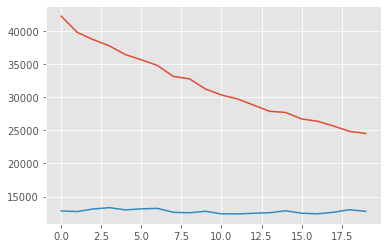

In [128]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')


4864

In [129]:
test_preds = np.array([])
for i, (inputs, targets) in enumerate(val_loader):
    preds = net(inputs.float())
    preds = preds.detach().numpy()
    test_preds = np.append(test_preds, preds)
    


In [130]:
test_preds.shape

(4851,)

In [131]:
full_df

,SEASON_YEAR,home_team_abbr,away_team_abbr,GAME_ID,GAME_DATE,MATCHUP,HOME_GAME,WL,home_P1_MIN,home_P1_FG2M,home_P1_FG2A,home_P1_FG3M,home_P1_FG3A,home_P1_FTM,home_P1_FTA,home_P1_OREB,home_P1_DREB,home_P1_AST,home_P1_TOV,home_P1_STL,home_P1_BLK,home_P1_BLKA,home_P1_PF,home_P1_PFD,home_P1_PTS,home_P1_PLUS_MINUS,home_P1_E_OFF_RATING,home_P1_E_DEF_RATING,home_P1_AST_RATIO,home_P1_TM_TOV_PCT,home_P1_E_USG_PCT,home_P1_PACE_PER40,home_P1_POSS,home_P1_PIE,home_P1_PTS_2PT,home_P1_PTS_2PT_MR,home_P1_PTS_3PT,home_P1_PTS_FB,home_P1_PTS_OFF_TOV,home_P1_PTS_PAINT,home_P1_AST_2PM,home_P1_UAST_2PM,home_P1_AST_3PM,home_P1_UAST_3PM,home_P2_MIN,home_P2_FG2M,home_P2_FG2A,home_P2_FG3M,home_P2_FG3A,home_P2_FTM,home_P2_FTA,home_P2_OREB,home_P2_DREB,home_P2_AST,home_P2_TOV,home_P2_STL,home_P2_BLK,home_P2_BLKA,home_P2_PF,home_P2_PFD,home_P2_PTS,home_P2_PLUS_MINUS,home_P2_E_OFF_RATING,home_P2_E_DEF_RATING,home_P2_AST_RATIO,home_P2_TM_TOV_PCT,home_P2_E_USG_PCT,home_P2_PACE_PER40,home_P2_POSS,home_P2_PIE,home_P2_PTS_2PT,home_P2_PTS_2PT_MR,home_P2_PTS_3PT,home_P2_PTS_FB,home_P2_PTS_OFF_TOV,home_P2_PTS_PAINT,home_P2_AST_2PM,home_P2_UAST_2PM,home_P2_AST_3PM,home_P2_UAST_3PM,home_P3_MIN,home_P3_FG2M,home_P3_FG2A,home_P3_FG3M,home_P3_FG3A,home_P3_FTM,home_P3_FTA,home_P3_OREB,home_P3_DREB,home_P3_AST,home_P3_TOV,home_P3_STL,home_P3_BLK,home_P3_BLKA,home_P3_PF,home_P3_PFD,home_P3_PTS,home_P3_PLUS_MINUS,home_P3_E_OFF_RATING,home_P3_E_DEF_RATING,...,away_P8_PACE_PER40,away_P8_POSS,away_P8_PIE,away_P8_PTS_2PT,away_P8_PTS_2PT_MR,away_P8_PTS_3PT,away_P8_PTS_FB,away_P8_PTS_OFF_TOV,away_P8_PTS_PAINT,away_P8_AST_2PM,away_P8_UAST_2PM,away_P8_AST_3PM,away_P8_UAST_3PM,away_P9_MIN,away_P9_FG2M,away_P9_FG2A,away_P9_FG3M,away_P9_FG3A,away_P9_FTM,away_P9_FTA,away_P9_OREB,away_P9_DREB,away_P9_AST,away_P9_TOV,away_P9_STL,away_P9_BLK,away_P9_BLKA,away_P9_PF,away_P9_PFD,away_P9_PTS,away_P9_PLUS_MINUS,away_P9_E_OFF_RATING,away_P9_E_DEF_RATING,away_P9_AST_RATIO,away_P9_TM_TOV_PCT,away_P9_E_USG_PCT,away_P9_PACE_PER40,away_P9_POSS,away_P9_PIE,away_P9_PTS_2PT,away_P9_PTS_2PT_MR,away_P9_PTS_3PT,away_P9_PTS_FB,away_P9_PTS_OFF_TOV,away_P9_PTS_PAINT,away_P9_AST_2PM,away_P9_UAST_2PM,away_P9_AST_3PM,away_P9_UAST_3PM,away_P10_MIN,away_P10_FG2M,away_P10_FG2A,away_P10_FG3M,away_P10_FG3A,away_P10_FTM,away_P10_FTA,away_P10_OREB,away_P10_DREB,away_P10_AST,away_P10_TOV,away_P10_STL,away_P10_BLK,away_P10_BLKA,away_P10_PF,away_P10_PFD,away_P10_PTS,away_P10_PLUS_MINUS,away_P10_E_OFF_RATING,away_P10_E_DEF_RATING,away_P10_AST_RATIO,away_P10_TM_TOV_PCT,away_P10_E_USG_PCT,away_P10_PACE_PER40,away_P10_POSS,away_P10_PIE,away_P10_PTS_2PT,away_P10_PTS_2PT_MR,away_P10_PTS_3PT,away_P10_PTS_FB,away_P10_PTS_OFF_TOV,away_P10_PTS_PAINT,away_P10_AST_2PM,away_P10_UAST_2PM,away_P10_AST_3PM,away_P10_UAST_3PM,date,home_score,away_score,point_diff_x,rest,point_total,spread,total,covered_spread,over,prev_cover,prev2_cover,home_rating_i,away_rating_i,point_diff_y
0,2000-01,PHX,ATL,20000077,2000-11-09,PHX vs. ATL,1,1,41.829333,4.0,9.4,1.6,3.4,5.2,6.2,0.8,6.6,10.6,4.8,3.2,0.2,0.8,3.2,0.0,18.0,9.2,102.96,93.06,35.58,15.52,0.2046,81.060,84.8,0.1794,7.9996,1.6004,4.8012,3.6004,4.2008,6.3992,1.2006,2.7994,1.4000,0.2000,38.260000,6.6,14.4,0.6,4.2,4.0,5.2,2.0,2.0,3.8,1.6,1.8,1.6,1.4,2.0,0.0,19.0,1.6,98.52,98.16,14.90,6.42,0.2732,78.264,75.0,0.0996,13.1982,3.204600e+00,1.8012,2.0008,4.0036,9.9960,5.2008,1.3992,0.6000,0.0000,36.473000,6.6,11.0,0.8,2.8,2.6,3.0,2.0,6.0,1.6,1.8,1.6,1.6,0.4,2.6,0.0,18.2,4.2,97.56,94.40,...,0.000,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0000,0.000,0.0,0.0000,0.0000,0.0000,0.0000

## Against the Spread

In [132]:
test_preds

array([ 0.19983912, -6.63105249,  7.06274509, ...,  0.19983912,
        1.29949594,  2.80058765])

In [74]:
pd.options.display.max_rows=120

In [135]:

betting_results = full_df.loc[test_idx, ['GAME_DATE', 'spread']]
betting_results['actual_point_diff'] = y_test
betting_results['prediction'] = test_preds
# betting_results = betting_results.loc[~betting_results['spread'].isnull()]

betting_results['bet_home_team'] = (betting_results['prediction'] + betting_results['spread'] > 0).astype(int)

betting_results['home_covered'] = (betting_results['actual_point_diff'] + betting_results['spread'] > 0).astype(int)
betting_results['profit'] = betting_results.apply(lambda row: 100 if row['bet_home_team'] == row['home_covered'] else -110, axis=1)
betting_results['cume_profit'] = betting_results['profit'].cumsum()


# betting_results['random_profit'] = np.random.choice([100, -110], betting_results.shape[0])
# betting_results['random_cume_profit'] = betting_results['random_profit'].cumsum()
# betting_results['prediction+spread'] = round(betting_results['prediction'] + betting_results['spread'], 2)
# # betting_results.loc[betting_results['prediction+spread'].]

betting_results['bet_home_team'].value_counts()
betting_results


,GAME_DATE,spread,actual_point_diff,prediction,bet_home_team,home_covered,profit,cume_profit
19515,2016-11-30,4.0,2,0.199839,1,1,100,100
19516,2016-11-30,8.5,-7,-6.631052,1,1,100,200
19517,2016-11-30,-10.5,-6,7.062745,0,0,100,300
19518,2016-11-30,-6.5,-7,1.541033,0,0,100,400
19519,2016-11-30,-13.0,15,2.971010,0,1,-110,290
...,...,...,...,...,...,...,...,...
24417,2021-02-15,5.0,-11,0.071612,1,0,-110,16400
24418,2021-02-15,-8.5,11,8.344717,0,1,-110,16290
24419,2021-02-15,-2.0,12,0.199839,0,1,-110,16180
24420,2021-02-15,-4.5,-8,1.299496,0,0,100,16280


In [136]:
betting_results['profit'].value_counts()

 100    2618
-110    2233
Name: profit, dtype: int64

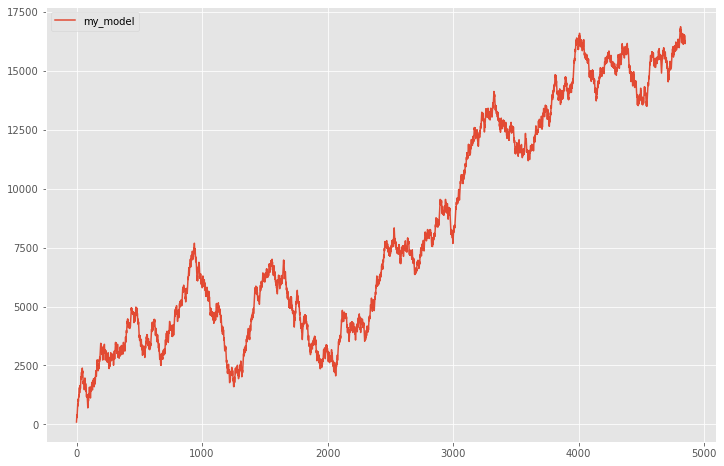

In [137]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(range(len(betting_results)), betting_results['cume_profit'], label='my_model')
# ax.plot(range(len(betting_results)), betting_results['random_cume_profit'], label='random')
plt.legend()

In [138]:
betting_results.head(20)

,GAME_DATE,spread,actual_point_diff,prediction,bet_home_team,home_covered,profit,cume_profit
19515,2016-11-30,4.0,2,0.199839,1,1,100,100
19516,2016-11-30,8.5,-7,-6.631052,1,1,100,200
19517,2016-11-30,-10.5,-6,7.062745,0,0,100,300
19518,2016-11-30,-6.5,-7,1.541033,0,0,100,400
19519,2016-11-30,-13.0,15,2.971010,0,1,-110,290
19520,2016-11-30,-7.5,22,9.611731,1,1,100,390
19521,2016-11-30,-6.5,-8,-2.915856,0,0,100,490
19522,2016-11-30,-3.5,-2,1.119079,0,0,100,590
19523,2016-11-30,-5.0,11,5.119329,1,1,100,690
19524,2016-12-01,-3.5,-19,1.297345,0,0,100,790


In [369]:
betting_results['profit'].value_counts()

 100    805
-110    774
Name: profit, dtype: int64

In [517]:
from sklearn.metrics import confusion_matrix

confusion_matrix(betting_results['home_covered'], betting_results['bet_home_team'])


array([[552, 274],
       [495, 258]], dtype=int64)

## Using the model
1. Update datasets
2. Gather Data
3. Aggregate - Find Player Last 10 game Averages
4. Create Matchups for upcoming games
5. Feed into Model
6. Get betting lines
7. Use Model outputs and lines to make bet recommendations 

In [145]:
# Functions to update data

def update_player_gamelogs(season='2020-21', season_type='Regular Season'):
    player_gamelogs = playergamelogs.PlayerGameLogs(season_nullable=season, season_type_nullable=season_type).get_data_frames()[0]
    path = './data/basic_player_boxscores/player_boxscores_{}.csv'.format(season)
    player_gamelogs.to_csv(path, index=False)
        
    return None

def update_advanced_boxscores(season='2020-21', season_type='Regular Season'):
    # Pull the GAME_IDs from my data
    current_player_boxscores = pd.read_csv('./data/advanced_player_boxscores/player_advanced_boxscores_{}.csv'.format(season), dtype={'GAME_ID':'object'})
    current_team_boxscores = pd.read_csv('./data/advanced_team_boxscores/team_advanced_boxscores_{}.csv'.format(season), dtype={'GAME_ID':'object'})

    current_game_ids = current_team_boxscores['GAME_ID'].unique()

    # get up to date GAME_IDs
    to_date_game_ids = []
    for season_type in ['Regular Season', 'Playoffs']:
        to_date_gamelogs = leaguegamelog.LeagueGameLog(season=season, season_type_all_star=season_type).get_data_frames()[0]
        to_date_game_ids.extend(to_date_gamelogs['GAME_ID'].unique())


    # See which game_ids are missing
    missing_game_ids = set(to_date_game_ids) - set(current_game_ids)
    num_games_updated = len(missing_game_ids)
    
    if num_games_updated == 0:
        print("Already Up to Date!")
        return None
    
    season_player_boxscores = []
    season_team_boxscores = []
    
    for game_id in tqdm(missing_game_ids, desc='progress'):
        boxscores = boxscoreadvancedv2.BoxScoreAdvancedV2(game_id).get_data_frames()
        season_player_boxscores.append(boxscores[0])
        season_team_boxscores.append(boxscores[1])    
        sleep(2)
        
    new_player_boxscores = pd.concat(season_player_boxscores)
    new_team_boxscores = pd.concat(season_team_boxscores)
    
    updated_player_boxscores = pd.concat([current_player_boxscores, new_player_boxscores])
    updated_team_boxscores = pd.concat([current_team_boxscores, new_team_boxscores])
   
    updated_player_boxscores.to_csv('./data/advanced_player_boxscores/player_advanced_boxscores_{}.csv'.format(season), index=False)
    updated_team_boxscores.to_csv('./data/advanced_team_boxscores/team_advanced_boxscores_{}.csv'.format(season), index=False)

    print("Games Added to Advanced Boxscores: {}".format(num_games_updated))

    return None


def update_scoring_boxscores(season='2020-21'):
    # Pull the GAME_IDs from my data
    current_player_boxscores = pd.read_csv('./data/scoring_player_boxscores/player_scoring_boxscores_{}.csv'.format(season), dtype={'GAME_ID':'object'})
    current_team_boxscores = pd.read_csv('./data/scoring_team_boxscores/team_scoring_boxscores_{}.csv'.format(season), dtype={'GAME_ID':'object'})

    current_game_ids = current_team_boxscores['GAME_ID'].unique()

    # get up to date GAME_IDs
    to_date_game_ids = []
    for season_type in ['Regular Season', 'Playoffs']:
        to_date_gamelogs = leaguegamelog.LeagueGameLog(season=season, season_type_all_star=season_type).get_data_frames()[0]
        to_date_game_ids.extend(to_date_gamelogs['GAME_ID'].unique())


    # See which game_ids are missing
    missing_game_ids = set(to_date_game_ids) - set(current_game_ids)
    num_games_updated = len(missing_game_ids)
    
    if num_games_updated == 0:
        print("Already Up to Date!")
        return None
    
    season_player_boxscores = []
    season_team_boxscores = []
    for game_id in tqdm(missing_game_ids, desc='progress'):
        boxscores = boxscorescoringv2.BoxScoreScoringV2(game_id).get_data_frames()
        season_player_boxscores.append(boxscores[0])
        season_team_boxscores.append(boxscores[1])    
        
    new_player_boxscores = pd.concat(season_player_boxscores)
    new_team_boxscores = pd.concat(season_team_boxscores)
    
    updated_player_boxscores = pd.concat([current_player_boxscores, new_player_boxscores])
    updated_team_boxscores = pd.concat([current_team_boxscores, new_team_boxscores])
   
    updated_player_boxscores.to_csv('./data/scoring_player_boxscores/player_scoring_boxscores_{}.csv'.format(season), index=False)
    updated_team_boxscores.to_csv('./data/scoring_team_boxscores/team_scoring_boxscores_{}.csv'.format(season), index=False)
    
    print("Games Added to Scoring Boxscores: {}".format(num_games_updated))
    
    return None


update_player_gamelogs(season='2020-21')
update_advanced_boxscores(season='2020-21')
update_scoring_boxscores(season='2020-21')


progress:   0%|                                                                                 | 0/13 [00:00<?, ?it/s]

Already Up to Date!


progress: 100%|████████████████████████████████████████████████████████████████████████| 13/13 [00:08<00:00,  1.46it/s]


Games Added to Scoring Boxscores: 13


In [154]:
player_df_inputs = gather_data(seasons=['2020-21'])
player_df_inputs

,SEASON_YEAR,PLAYER_ID,PLAYER_NAME,TEAM_ABBREVIATION,home_team_abbr,away_team_abbr,GAME_ID,GAME_DATE,MATCHUP,HOME_GAME,WL,MIN,FG2M,FG2A,FG3M,FG3A,FTM,FTA,OREB,DREB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,E_OFF_RATING,E_DEF_RATING,AST_RATIO,TM_TOV_PCT,E_USG_PCT,PACE_PER40,POSS,PIE,PTS_2PT,PTS_2PT_MR,PTS_3PT,PTS_FB,PTS_OFF_TOV,PTS_PAINT,AST_2PM,UAST_2PM,AST_3PM,UAST_3PM
0,2020-21,1627736,Malik Beasley,MIN,NYK,MIN,22000469,2021-02-21,MIN @ NYK,0,0,37.933333,0,2,2,4,0,0,0,4,2,1,1,0,0,1,1,6,5,103.5,100.9,22.2,11.1,0.082,80.14,76,0.055,0.000,0.000,6.000,3.000,0.0,0.000,0.0,0.0,2.0,0.0
1,2020-21,203991,Clint Capela,ATL,ATL,DEN,22000470,2021-02-21,ATL vs. DEN,1,1,31.801667,8,9,0,0,6,8,2,8,1,2,0,1,0,3,4,22,5,127.3,113.3,6.3,12.5,0.208,86.16,68,0.160,15.994,0.000,0.000,0.000,0.0,15.994,7.0,1.0,0.0,0.0
2,2020-21,1627742,Brandon Ingram,NOP,NOP,BOS,22000465,2021-02-21,NOP vs. BOS,1,1,42.533333,6,10,5,12,6,6,1,5,3,2,0,0,2,3,6,33,2,103.4,98.3,10.0,6.7,0.276,82.29,87,0.183,12.012,3.993,15.015,6.006,0.0,7.986,3.0,3.0,3.0,2.0
3,2020-21,203488,Mike Muscala,OKC,CLE,OKC,22000466,2021-02-21,OKC @ CLE,0,1,17.331667,2,2,3,9,0,0,1,4,1,1,0,0,0,2,0,13,20,134.5,89.6,7.7,7.7,0.276,87.70,39,0.129,4.004,2.002,8.996,0.000,0.0,2.002,1.0,1.0,3.0,0.0
4,2020-21,1629610,DaQuan Jeffries,SAC,MIL,SAC,22000471,2021-02-21,SAC @ MIL,0,0,39.583333,3,8,2,5,6,7,2,4,2,0,1,1,2,5,7,18,0,105.6,104.9,11.1,0.0,0.160,89.43,88,0.079,5.994,0.000,5.994,0.000,0.0,5.994,3.0,0.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9531,2020-21,204020,Tyler Johnson,BKN,BKN,GSW,22000001,2020-12-22,BKN vs. GSW,1,1,5.983333,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,-12,69.2,164.6,0.0,0.0,0.063,90.25,14,0.018,0.000,0.000,0.000,0.000,0.0,0.000,0.0,0.0,0.0,0.0
9532,2020-21,202704,Reggie Jackson,LAC,LAL,LAC,22000002,2020-12-22,LAC @ LAL,0,1,3.350000,0,1,0,2,0,0,0,1,0,0,0,0,0,1,1,0,-1,22.2,37.5,0.0,0.0,0.333,101.49,9,-3.000,0.000,0.000,0.000,0.000,0.0,0.000,0.0,0.0,0.0,0.0
9533,2020-21,1629066,Rodions Kurucs,BKN,BKN,GSW,22000001,2020-12-22,BKN vs. GSW,1,1,6.600000,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,3,-9,85.7,142.3,0.0,0.0,0.059,90.91,15,0.129,0.000,0.000,3.000,0.000,0.0,0.000,0.0,0.0,1.0,0.0
9534,2020-21,1626172,Kevon Looney,GSW,BKN,GSW,22000001,2020-12-22,GSW @ BKN,0,0,11.283333,2,4,0,0,0,1,0,2,0,2,0,0,0,3,2,4,-10,95.6,136.4,0.0,33.3,0.192,97.49,27,-0.036,4.000,0.000,0.000,0.000,2.0,4.000,2.0,0.0,0.0,0.0


In [166]:
test = player_df_inputs.loc[player_df_inputs['PLAYER_NAME'] == 'LeBron James']
test.iloc[-10:, 11:].mean().values


array([ 32.79283333,   6.8       ,  12.5       ,   2.2       ,
         6.        ,   4.4       ,   6.        ,   0.8       ,
         7.6       ,   7.8       ,   3.7       ,   0.9       ,
         0.3       ,   1.        ,   1.2       ,   5.        ,
        24.6       ,   8.9       , 115.84      , 103.32      ,
        23.8       ,  11.48      ,   0.326     ,  84.173     ,
        69.        ,   0.184     ,  13.6022    ,   2.4008    ,
         6.5954    ,   4.4013    ,   3.0997    ,  11.2008    ,
         2.0999    ,   4.7001    ,   0.7998    ,   1.4002    ])

In [216]:
np.array(['LAL'])

array(['LAL'], dtype='<U3')

In [316]:
def last_10_avg(df = player_df_inputs):

    # Find players last 10 game averages
    df = df.sort_values('GAME_DATE')
    
    player_last_10 = []
    
    player_ids = df['PLAYER_ID'].unique()
    for p_id in tqdm(player_ids, desc='Progress'):
        player_log = df.loc[df['PLAYER_ID'] == p_id]
        
        team = np.array(player_log[['TEAM_ABBREVIATION', 'PLAYER_NAME']].iloc[-1])
        avg_player_data = player_log.iloc[-10:, 11:].mean().values
        
        player_row = np.concatenate([team, avg_player_data])
        
        player_last_10.append(player_row)
        
    cols = ['TEAM_ABBREVIATION', 'PLAYER_NAME']
    cols.extend(df.columns[11:])
    new_df = pd.DataFrame(np.stack(player_last_10), columns = cols)
    
    for col in cols[2:]:
        new_df[col] = new_df[col].astype(float)
        
        
        
        
    ## Turn data into long format
    long_data = []
    for team in new_df['TEAM_ABBREVIATION'].unique():
        team_df = new_df.loc[new_df['TEAM_ABBREVIATION'] == team].sort_values('MIN', ascending=False)
        team_row = team_df.iloc[:10, 2:].values.flatten()
        team_row = np.append(np.array([team]), team_row)
        long_data.append(team_row)
        
    long_data = np.stack(long_data)
    long_data = pd.DataFrame(long_data)    
    for col in long_data.columns[1:]:
        long_data[col] = long_data[col].astype(float)

    return long_data.round(2)
    
player_stats_long = last_10_avg(df=player_df_inputs)
player_stats_long

Progress: 100%|█████████████████████████████████████████████████████████████████████| 485/485 [00:02<00:00, 216.81it/s]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,...,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360
0,BKN,37.22,5.2,8.7,3.1,7.4,5.8,6.6,0.8,8.0,11.2,3.8,1.3,0.8,1.0,2.3,5.2,25.5,6.2,121.83,112.68,33.42,11.22,0.28,82.69,76.8,0.19,10.40,0.8,9.3,1.8,2.90,9.60,1.0,4.2,0.7,2.4,37.09,7.6,13.6,2.5,6.1,5.9,6.7,0.3,7.1,4.7,3.4,0.7,1.9,0.8,2.5,5.3,28.6,5.7,121.51,111.46,15.24,11.84,0.30,86.50,80.3,0.14,15.2,7.0,7.5,4.2,2.6,8.2,4.4,3.2,1.9,0.6,35.20,8.0,13.4,2.5,6.4,3.9,4.5,1.4,3.1,5.7,2.6,1.0,0.6,1.2,2.8,3.0,27.4,6.0,122.56,114.72,18.72,9.17,0.30,84.83,74.8,0.14,16.0,...,2.80,1.30,0.70,1.40,0.3,0.50,2.10,1.40,7.50,-2.80,113.92,116.52,17.24,13.92,0.15,81.60,47.70,0.08,5.80,0.20,0.30,1.8,1.30,5.60,2.10,0.80,0.10,0.00,21.47,1.1,2.6,2.3,5.9,1.2,1.3,0.2,1.6,1.6,1.0,0.2,0.1,0.5,1.3,0.9,10.3,-0.6,119.54,117.26,12.20,9.54,0.21,81.33,44.1,0.05,2.2,1.2,6.9,1.2,1.3,1.0,0.8,0.3,2.1,0.2,21.44,1.33,3.00,0.67,2.33,2.00,2.00,0.00,4.33,3.00,1.67,0.67,0.33,0.0,1.33,1.33,6.67,14.00,114.57,88.23,29.27,12.73,0.15,88.67,47.00,0.11,2.67,0.00,2.0,2.00,1.66,2.67,0.67,0.67,0.67,0.00
1,GSW,34.58,5.5,7.9,6.2,13.1,4.7,4.9,0.1,5.1,6.1,3.0,1.3,0.0,0.3,1.2,4.0,34.3,9.2,119.61,107.27,19.12,9.21,0.32,86.87,75.6,0.21,11.00,1.4,18.6,3.6,5.90,9.60,2.9,2.6,3.7,2.5,33.95,5.0,8.9,1.7,5.5,2.4,3.7,0.7,3.8,2.2,2.3,1.0,0.9,0.6,2.1,3.4,17.5,5.0,110.93,103.60,10.70,10.82,0.24,85.24,72.5,0.09,10.0,2.4,5.1,2.7,2.7,7.6,2.6,2.4,1.4,0.3,33.60,4.4,9.0,2.9,6.3,2.3,3.0,1.7,4.8,1.7,1.1,1.0,0.6,1.1,2.5,2.7,19.8,-0.2,109.97,109.81,9.04,5.75,0.23,84.62,71.1,0.10,8.8,...,3.00,1.90,1.00,1.00,0.6,0.20,2.50,1.50,10.00,10.20,120.86,95.66,19.32,9.43,0.18,86.59,43.40,0.10,4.20,0.20,4.50,2.8,1.60,4.00,1.50,0.60,1.40,0.10,17.73,3.6,6.3,0.3,0.8,1.6,2.4,0.8,3.2,1.1,1.5,0.1,0.1,0.6,1.3,1.9,9.7,0.0,101.99,105.32,10.05,13.88,0.26,82.86,37.1,0.11,7.2,2.4,0.9,0.9,1.6,4.8,1.5,2.1,0.3,0.0,16.86,0.80,2.50,0.40,1.60,1.50,1.70,0.40,1.80,2.50,1.10,1.10,0.10,0.3,1.20,1.90,4.30,1.40,99.76,101.85,32.49,11.37,0.15,82.22,35.10,0.08,1.60,0.20,1.2,1.10,0.90,1.40,0.40,0.40,0.40,0.00
2,LAL,37.68,8.6,13.2,1.6,6.4,4.5,6.3,0.3,8.8,8.9,4.0,1.3,0.7,0.6,1.8,5.5,26.5,5.2,107.55,101.08,25.81,11.20,0.31,82.88,77.8,0.21,17.20,2.6,4.8,6.4,5.30,14.60,2.8,5.8,0.9,0.7,33.48,9.2,15.8,0.4,2.2,4.4,6.5,2.1,5.5,2.6,2.3,1.5,1.6,0.9,2.2,4.3,24.0,1.4,110.03,108.33,10.21,9.24,0.31,82.32,68.4,0.16,18.4,4.0,1.2,2.3,3.4,14.4,5.6,3.6,0.4,0.0,31.94,4.0,7.4,0.9,2.6,4.6,5.4,0.5,2.9,4.6,2.2,0.8,0.3,0.8,2.8,4.9,15.3,-0.2,108.41,109.22,24.50,11.99,0.21,81.06,64.7,0.10,8.0,...,3.30,1.80,0.60,0.50,1.3,0.20,2.20,0.80,5.50,-1.40,100.44,103.93,24.35,6.04,0.12,81.89,44.10,0.08,1.20,0.20,3.60,0.0,0.50,1.00,0.50,0.10,1.20,0.00,21.08,1.5,2.5,0.3,1.9,0.6,0.7,0.6,2.1,2.6,1.5,1.0,0.1,0.0,2.1,1.4,4.5,1.5,106.00,100.65,30.66,14.29,0.13,82.25,43.3,0.06,3.0,0.2,0.9,0.6,0.2,2.8,1.1,0.4,0.3,0.0,19.03,2.50,4.60,0.20,1.50,0.70,0.90,0.10,2.20,2.30,1.30,0.70,0.80,0.3,1.80,1.20,6.30,-3.90,104.44,118.16,20.46,12.80,0.18,82.78,39.00,0.04,5.00,0.00,0.6,1.10,0.80,5.00,1.50,1.00,0.10,0.10
3,CLE,37.35,6.7,13.7,1.1,3.4,4.6,5.8,0.8,2.0,4.3,2.2,1.0,0.1,1.3,2.8,5.0,21.3,-12.7,101.40,121.09,17.24,8.68,0.24,82.50,77.4,0.09,13.40,1.8,3.3,3.3,4.40,11.60,2.4,4.3,0.7,0.4,33.97,5.7,11.3,1.4,3.8,1.4,1.6,0.5,1.4,5.9,1.9,1.0,0.0,0.7,2.4,2.4,17.0,-17.8,99.95,125.54,25.54,8.04,0.22,81.41,69.4,0.09,11.4,2.4,4.2,1.1,1.9,9.0,1.2,4.5,1.1,0.3,32.48,2.4,4.5,1.2,3.2,0.6,0.9,1.3,6.1,2.2,1.3,1.5,0.5,0.3,2.2,1.3,9.0,-5.0,99.79

In [317]:
player_stats_long.loc[player_stats_long[0] == 'BKN']

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,...,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360
0,BKN,37.22,5.2,8.7,3.1,7.4,5.8,6.6,0.8,8.0,11.2,3.8,1.3,0.8,1.0,2.3,5.2,25.5,6.2,121.83,112.68,33.42,11.22,0.28,82.69,76.8,0.19,10.4,0.8,9.3,1.8,2.9,9.6,1.0,4.2,0.7,2.4,37.09,7.6,13.6,2.5,6.1,5.9,6.7,0.3,7.1,4.7,3.4,0.7,1.9,0.8,2.5,5.3,28.6,5.7,121.51,111.46,15.24,11.84,0.3,86.5,80.3,0.14,15.2,7.0,7.5,4.2,2.6,8.2,4.4,3.2,1.9,0.6,35.2,8.0,13.4,2.5,6.4,3.9,4.5,1.4,3.1,5.7,2.6,1.0,0.6,1.2,2.8,3.0,27.4,6.0,122.56,114.72,18.72,9.17,0.3,84.83,74.8,0.14,16.0,...,2.8,1.3,0.7,1.4,0.3,0.5,2.1,1.4,7.5,-2.8,113.92,116.52,17.24,13.92,0.15,81.6,47.7,0.08,5.8,0.2,0.3,1.8,1.3,5.6,2.1,0.8,0.1,0.0,21.47,1.1,2.6,2.3,5.9,1.2,1.3,0.2,1.6,1.6,1.0,0.2,0.1,0.5,1.3,0.9,10.3,-0.6,119.54,117.26,12.2,9.54,0.21,81.33,44.1,0.05,2.2,1.2,6.9,1.2,1.3,1.0,0.8,0.3,2.1,0.2,21.44,1.33,3.0,0.67,2.33,2.0,2.0,0.0,4.33,3.0,1.67,0.67,0.33,0.0,1.33,1.33,6.67,14.0,114.57,88.23,29.27,12.73,0.15,88.67,47.0,0.11,2.67,0.0,2.0,2.0,1.66,2.67,0.67,0.67,0.67,0.0


In [ ]:
def create_matchups(home_team, away_team, df=player_stats_long, elo_df=elo_df):
    
    home = df.loc[df[0] == home_team].values
    away = df.loc[df[0] == away_team].values

    
    matchup = np.concatenate([home[:, 1:], away[:, 1:]], axis=1)
    # Add ELO ratings
    
    new_elo_df, elo_dic = update_elo_df(elo_df)
    
    home_elo = elo_dic[home_team]
    away_elo = elo_dic[away_team]
    elos = [home_elo, away_elo]
    matchup = np.concatenate([matchup, np.array([[home_elo, away_elo]])], axis=1)
    matchup = np.float64(matchup)
    return matchup

create_matchups('HOU', 'CHI', df=player_stats_long, elo_df=elo_df)

In [356]:
from datetime import datetime
today = datetime.today().strftime('%Y-%m-%d')

from nba_api.stats.endpoints import scoreboardv2

todays_games = scoreboardv2.ScoreboardV2(game_date = today).get_data_frames()[0]
home_teams = list(todays_games['GAMECODE'].str[-3:])
away_teams = list(todays_games['GAMECODE'].str[-6:-3])
matchups = list(zip(home_teams, away_teams))
matchups

[('IND', 'SAS'),
 ('HOU', 'CHI'),
 ('DAL', 'MEM'),
 ('OKC', 'MIA'),
 ('PHX', 'POR'),
 ('UTA', 'CHA'),
 ('LAL', 'WAS')]

In [394]:
preds = []
home = []
away = []

data = gather_data(seasons=['2020-21'])
player_stats_long = last_10_avg(df=data)


home_teams = list(todays_games['GAMECODE'].str[-3:])
away_teams = list(todays_games['GAMECODE'].str[-6:-3])
matchups = list(zip(home_teams, away_teams))
matchups

for matchup in matchups:
    inputs = create_matchups(matchup[0], matchup[1], df=player_stats_long, elo_df=elo_df)
    inputs = scaler.transform(inputs)
    tensor_inputs = torch.Tensor(inputs)
    prediction = net(tensor_inputs)
    preds.append(prediction.item())
    home.append(matchup[0])
    away.append(matchup[1])

results = pd.DataFrame({'home_team':home, 'away_team':away, 'prediction':preds})

Progress: 100%|█████████████████████████████████████████████████████████████████████| 485/485 [00:02<00:00, 209.96it/s]


In [395]:
results

,home_team,away_team,prediction
0,IND,SAS,-1.656463
1,HOU,CHI,10.380144
2,DAL,MEM,-0.917769
3,OKC,MIA,4.531588
4,PHX,POR,4.882986
5,UTA,CHA,6.895903
6,LAL,WAS,21.534220


In [379]:
net(torch.Tensor(inputs))

tensor([[2145.2556]], grad_fn=<AddmmBackward>)